# Notebook for differential abundance testing on single-cell data for COPD project

- **Developed by:** Anna Maguza
- **Institute of Computational Biology - Computational Health Department - Helmholtz Munich**
- 27th March 2022

In [1]:
import scanpy as sc
import numpy as np

import milopy
import milopy.core as milo      

In [2]:
import matplotlib.pyplot as plt

In [3]:
import milopy.core as milo
import milopy.plot as milopl


In [33]:
import milopy.utils
milopy.utils.build_nhood_graph(adata)

#### Setup Cells

In [4]:
%matplotlib inline

In [5]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


scanpy==1.9.3 anndata==0.8.0 umap==0.5.3 numpy==1.23.5 scipy==1.10.1 pandas==1.5.3 scikit-learn==1.2.2 statsmodels==0.13.5 pynndescent==0.5.8


#### Upload Data

In [125]:
input_data = '/Users/anna.maguza/Desktop/Data/COPD_project/Marburg_All_ctl230321_leiden_states.raw.h5ad'
output_data = '/Users/anna.maguza/Desktop/Data/COPD_project/Marburg_All_ctl230321_leiden_states_output.h5ad'

In [126]:
adata = sc.read_h5ad(input_data)

In [127]:
# Merge column donor and column group into new column sample 
adata.obs["sample"] = adata.obs["donor"].astype(str) + "_" + adata.obs["group"].astype(str)

### Calculate UMAP

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


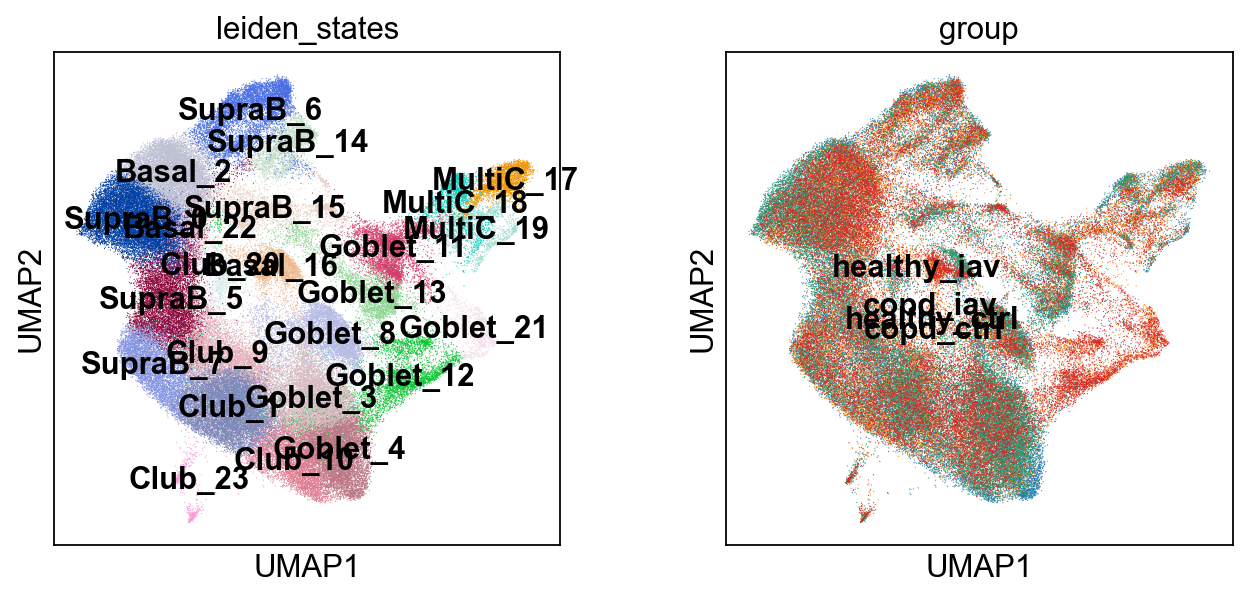

In [8]:
sc.pl.umap(adata, color=["leiden_states", 'group'], legend_loc="on data");

### Build KNN graph

In [9]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:34)


In [10]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:39)


### Construct neighbourhoods

In [11]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [12]:
adata.obsm["nhoods"]

<115102x8673 sparse matrix of type '<class 'numpy.float32'>'
	with 838198 stored elements in Compressed Sparse Row format>

In [ ]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
653582-ST07_CSE_CTRL-V1                  1          692.713684
608238-ST07_CSE_CTRL-V1                  1          910.884583
283002-ST07_CSE_CTRL-V1                  1         1144.949707
104170-ST07_CSE_CTRL-V1                  1          461.611298
691353-ST07_CSE_CTRL-V1                  1          572.247986
...                                    ...                 ...
3105063-CSE03_IAV-V6                     1          120.714577
10496296-CSE03_IAV-V6                    1          114.799019
5774685-CSE03_IAV-V6                     1          100.101357
3100806-CSE03_IAV-V6                     1           92.792992
8274833-CSE03_IAV-V6                     1          107.428925

[8673 rows x 2 columns]

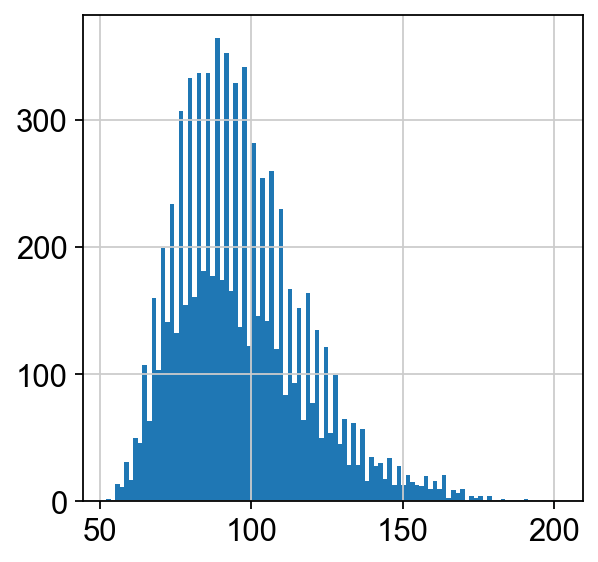

In [14]:
# Visualize the distribution of neighbourhood sizes to get an idea of the right value for k
nhood_size = np.array(adata.obsm["nhoods"].sum(0)).ravel()
plt.hist(nhood_size, bins=100);

### Count cells in neighbourhoods

In [27]:
milo.count_nhoods(adata, sample_col="sample")

In [28]:
adata.uns["nhood_adata"]

AnnData object with n_obs × n_vars = 8673 × 23
    obs: 'index_cell', 'kth_distance'
    uns: 'sample_col'

### Differential abundance testing with GLM

In [29]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [30]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [31]:
adata.uns["nhood_adata"].obs

index_cell  kth_distance     logFC    logCPM         F  \
0     653582-ST07_CSE_CTRL-V1    692.713684  0.004125  7.302278  0.000063   
1     608238-ST07_CSE_CTRL-V1    910.884583 -0.555887  7.180797  1.286961   
2     283002-ST07_CSE_CTRL-V1   1144.949707 -0.175192  7.170136  0.126428   
3     104170-ST07_CSE_CTRL-V1    461.611298 -0.112831  7.680705  0.043559   
4     691353-ST07_CSE_CTRL-V1    572.247986 -0.102515  7.227775  0.040548   
...                       ...           ...       ...       ...       ...   
8668     3105063-CSE03_IAV-V6    120.714577  0.108899  7.508052  0.055550   
8669    10496296-CSE03_IAV-V6    114.799019 -0.055199  7.627877  0.013915   
8670     5774685-CSE03_IAV-V6    100.101357  0.429615  7.204768  0.963603   
8671     3100806-CSE03_IAV-V6     92.792992  0.133983  7.551312  0.089093   
8672     8274833-CSE03_IAV-V6    107.428925  0.177284  7.178550  0.207812   

        PValue       FDR  SpatialFDR  
0     0.993667  0.999682     0.99974  
1     0.260665  0.806826     0.99974  
2     0.723285  0.963348     0.99974  
3     0.835312  0.979073     0.99974  
4     0.841026  0.979485     0.99974  
...        ...       ...         ...  
8668  0.814375  0.977042     0.99974  
8669  0.906441  0.986583     0.99974  
8670  0.329824  0.850054     0.99974  
8671  0.766235  0.969958     0.99974  
8672  0.649927  0.952687     0.99974  

[8673 rows x 8 columns]

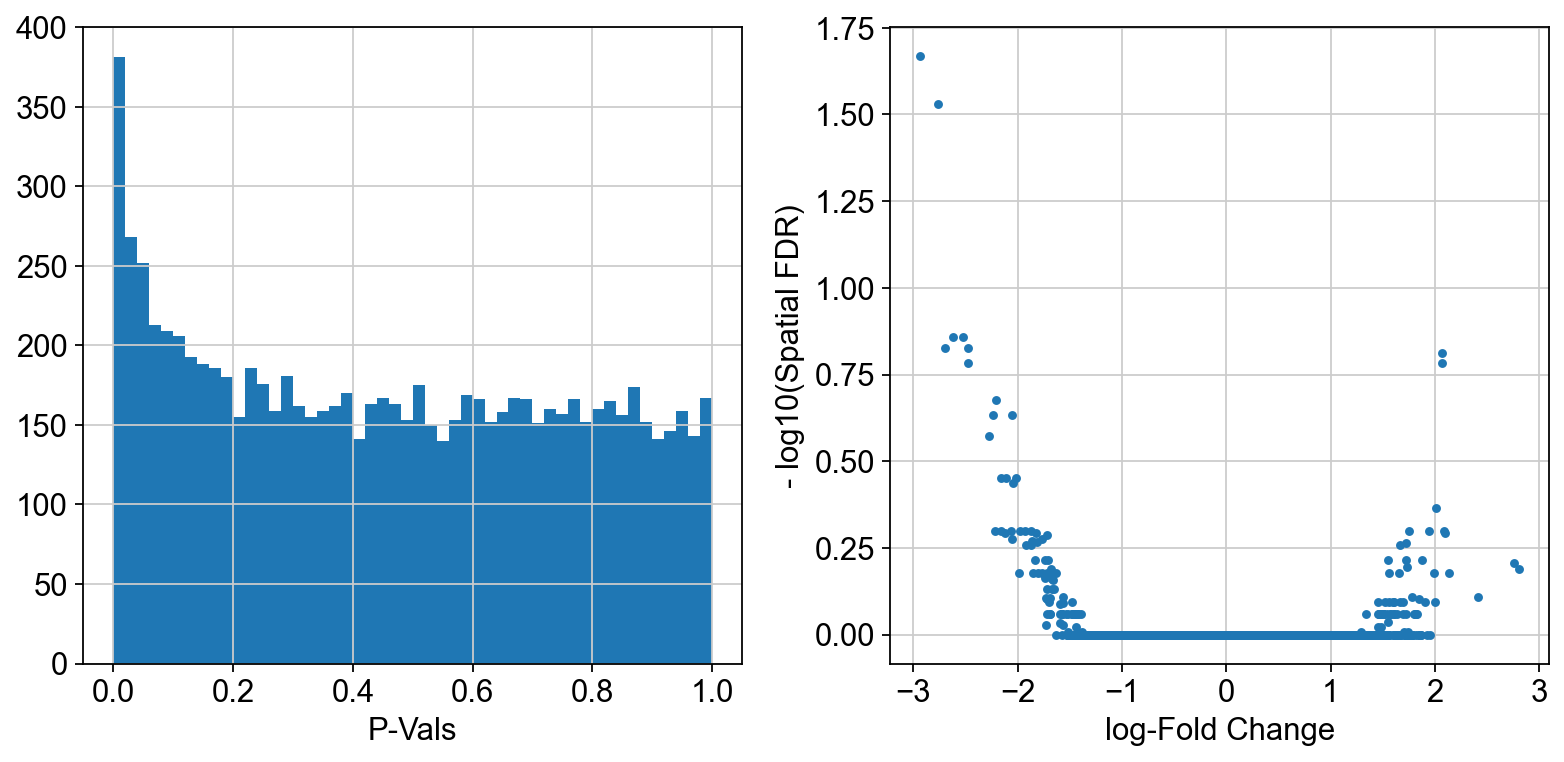

In [32]:
old_figsize = plt.rcParams["figure.figsize"]
plt.rcParams["figure.figsize"] = [10,5]
plt.subplot(1,2,1)
plt.hist(adata.uns["nhood_adata"].obs.PValue, bins=50);
plt.xlabel("P-Vals");
plt.subplot(1,2,2)
plt.plot(adata.uns["nhood_adata"].obs.logFC, -np.log10(adata.uns["nhood_adata"].obs.SpatialFDR), '.');
plt.xlabel("log-Fold Change");
plt.ylabel("- log10(Spatial FDR)");
plt.tight_layout()
plt.rcParams["figure.figsize"] = old_figsize

### Visualize result by celltype

In [35]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

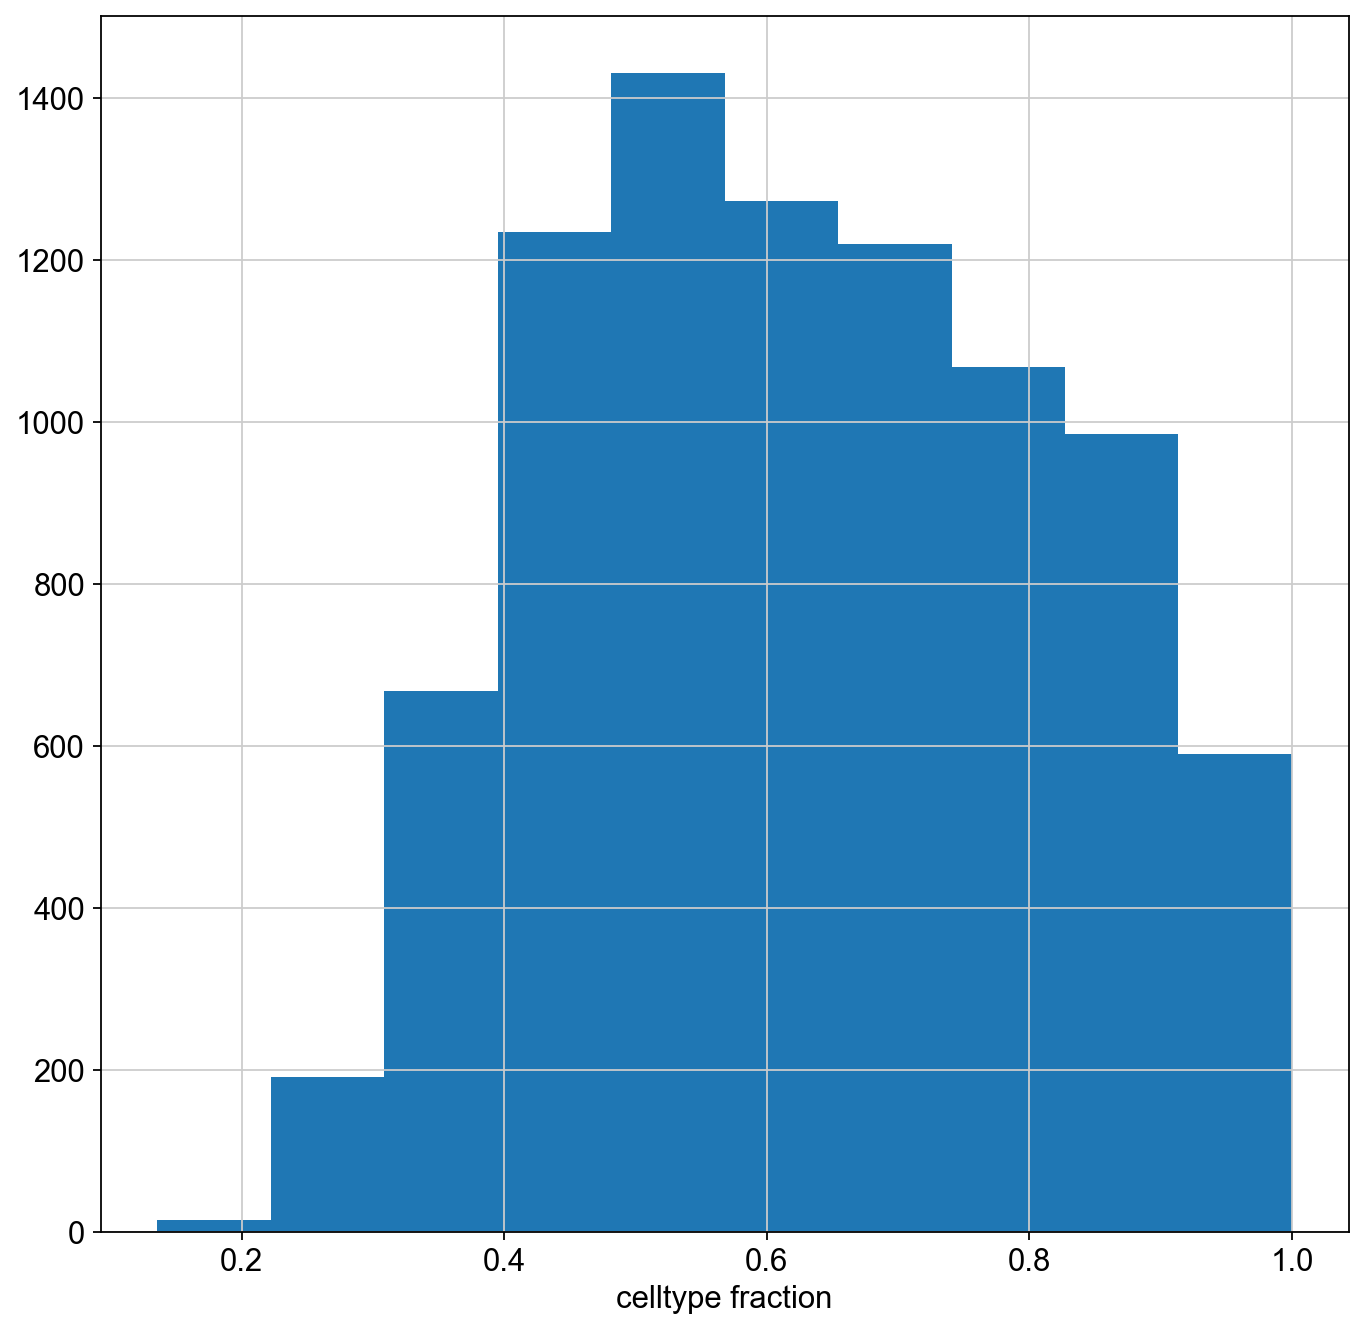

In [36]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [37]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

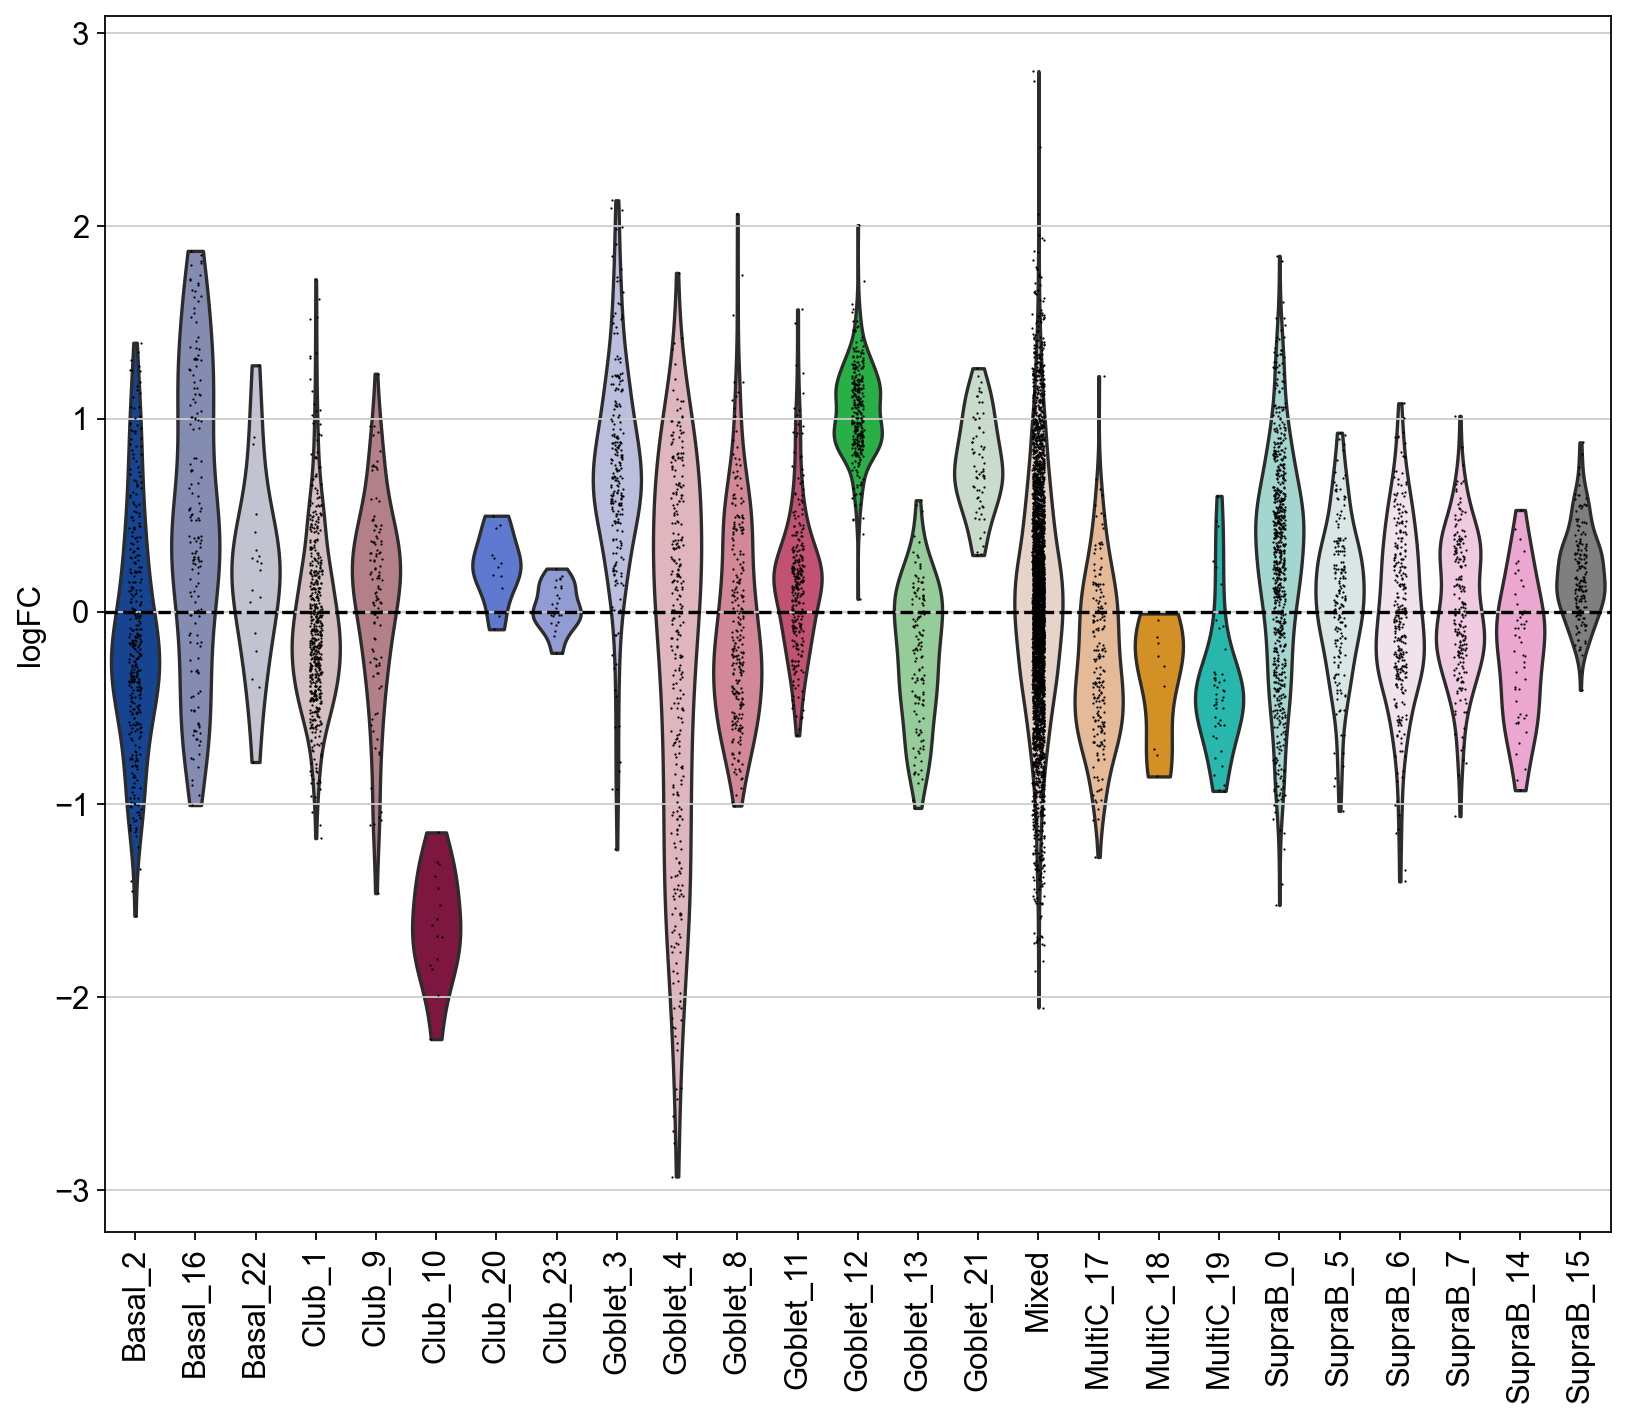

In [38]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# Healthy control vs. COPD

In [48]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_ctrl'])]

In [50]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:19)


In [51]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [52]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [53]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
763870-ST07_CSE_CTRL-V1                  1          872.918091
192197-ST07_CSE_CTRL-V1                  1          553.279358
104170-ST07_CSE_CTRL-V1                  1          529.000366
843133-ST07_CSE_CTRL-V1                  1          481.459412
50854-ST07_CSE_CTRL-V1                   1          970.155029
...                                    ...                 ...
7981477-CSE03_CTRL-V6                    1          170.909027
3101244-CSE03_CTRL-V6                    1          108.057228
5458228-CSE03_CTRL-V6                    1          102.910385
475852-CSE03_CTRL-V6                     1          103.748642
13874320-CSE03_CTRL-V6                   1          112.925758

[4435 rows x 2 columns]

In [54]:
milo.count_nhoods(adata, sample_col="sample")

In [55]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [56]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [57]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

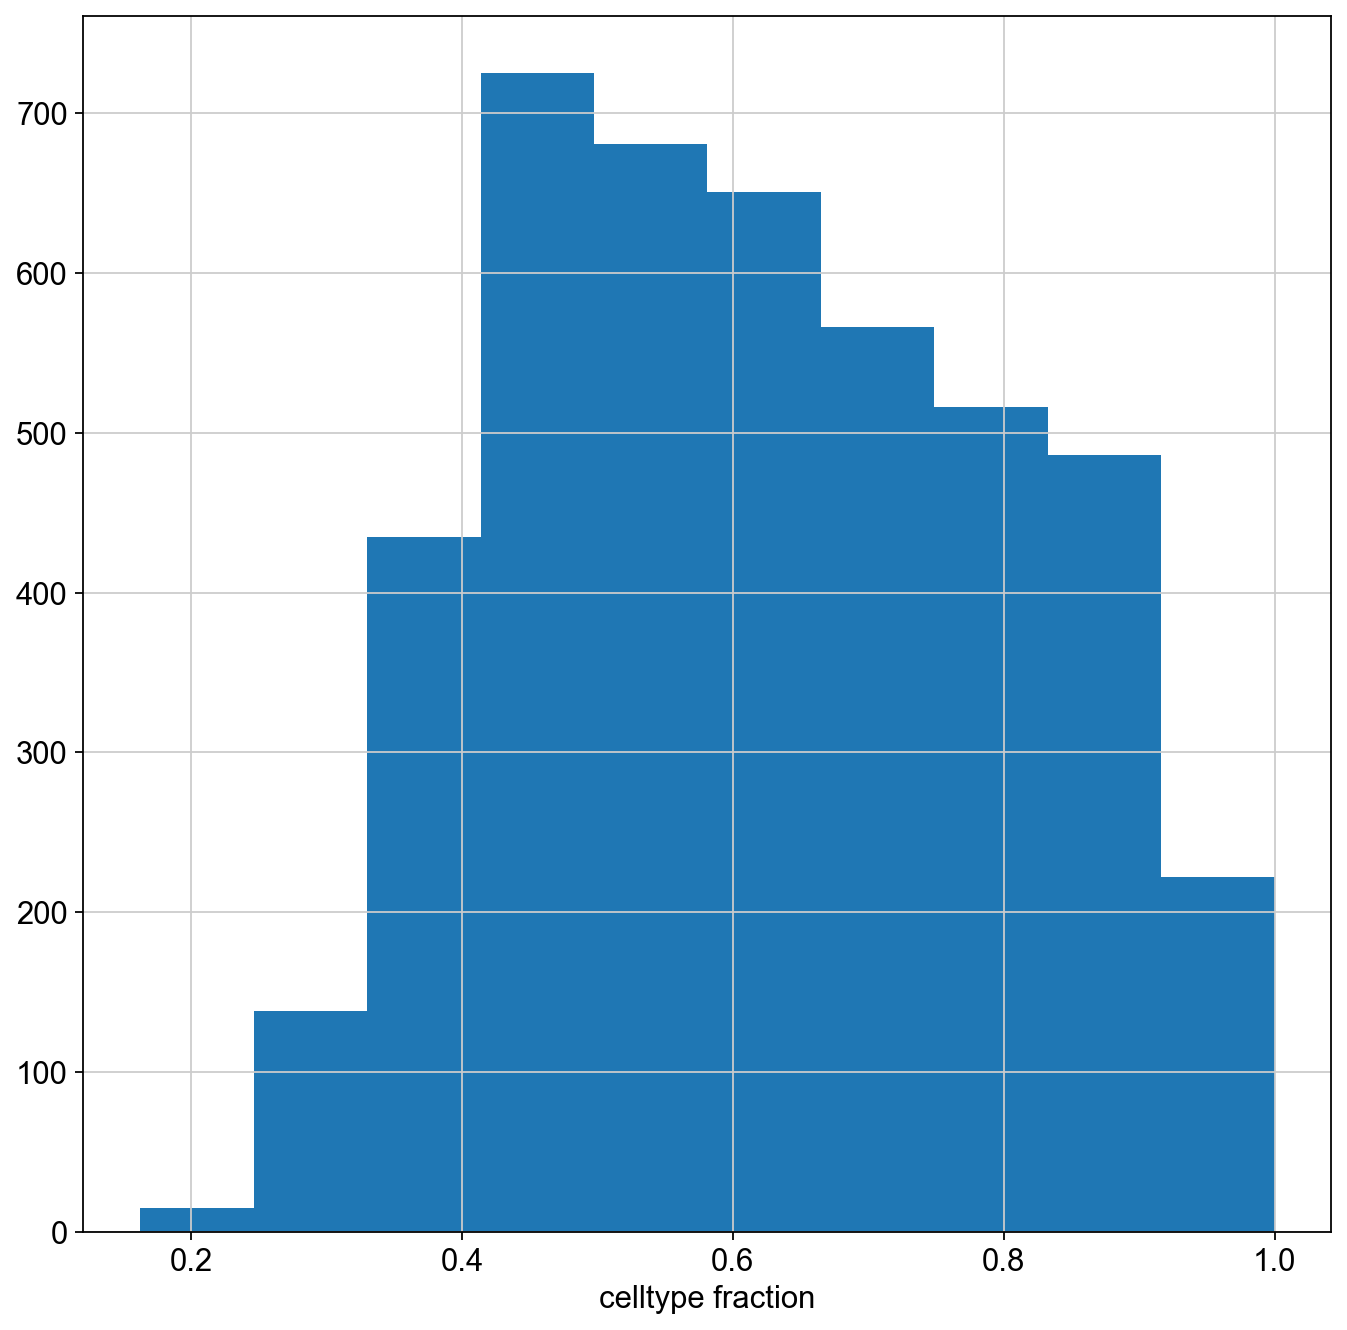

In [58]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [59]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

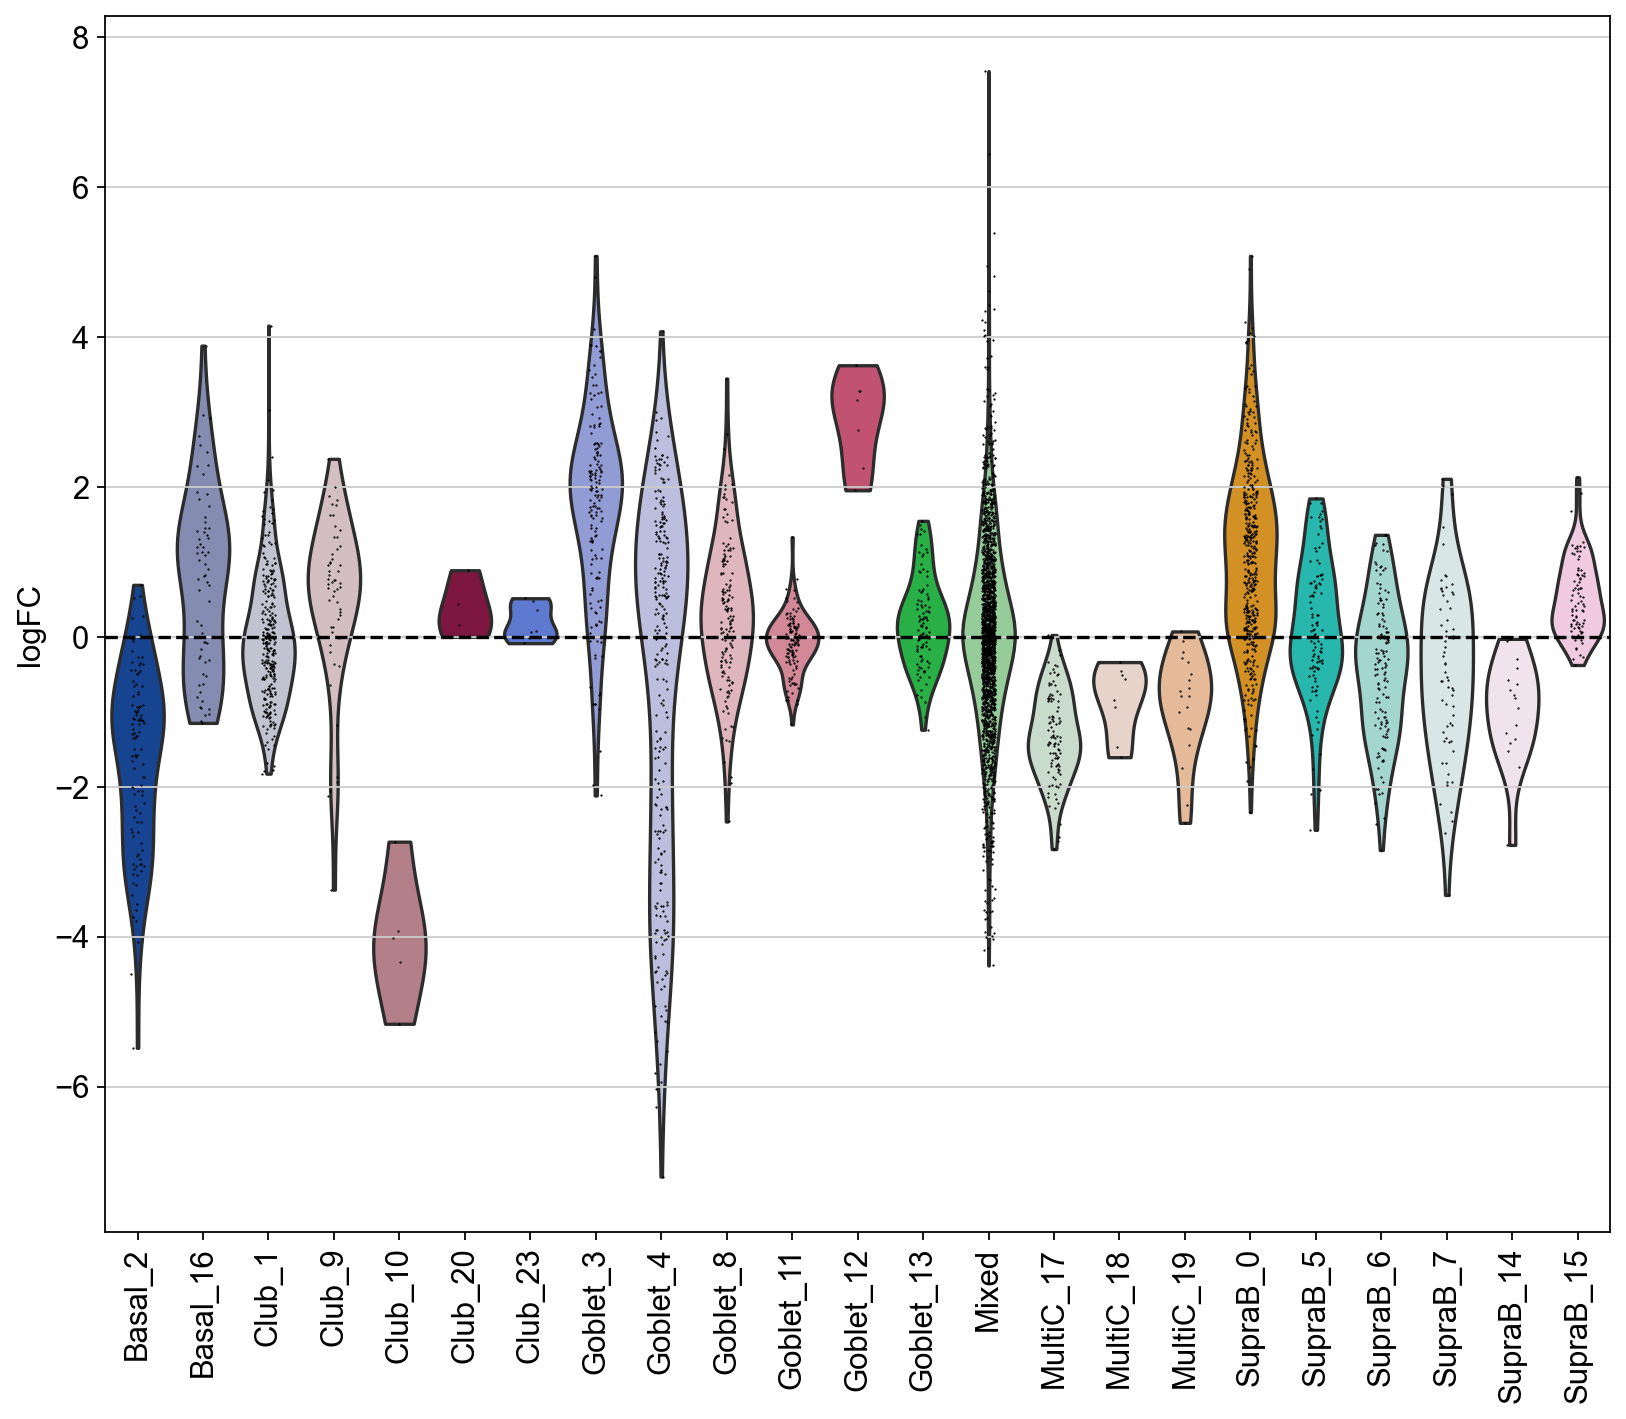

In [60]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# Healthy control vs. Influenza-infected

In [64]:
adata.obs['group'].value_counts()

copd_ctrl       30609
copd_iav        29157
healthy_ctrl    28175
healthy_iav     27161
Name: group, dtype: int64

In [65]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'healthy_iav'])]

In [66]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


In [67]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:15)


In [68]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [69]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
175621-ST07_CSE_CTRL-V1                  1         1680.585205
192197-ST07_CSE_CTRL-V1                  1          477.928101
104170-ST07_CSE_CTRL-V1                  1          508.538269
15014-ST07_CSE_CTRL-V1                   1          575.827515
50854-ST07_CSE_CTRL-V1                   1          975.625488
...                                    ...                 ...
11361479-GER02_IAV-V6                    1          133.802399
9149236-GER02_IAV-V6                     1          113.792145
10059290-GER02_IAV-V6                    1          102.814850
10502482-GER02_IAV-V6                    1          196.468094
6372548-GER02_IAV-V6                     1          115.249207

[4205 rows x 2 columns]

In [70]:
milo.count_nhoods(adata, sample_col="sample")

In [71]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [72]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [73]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

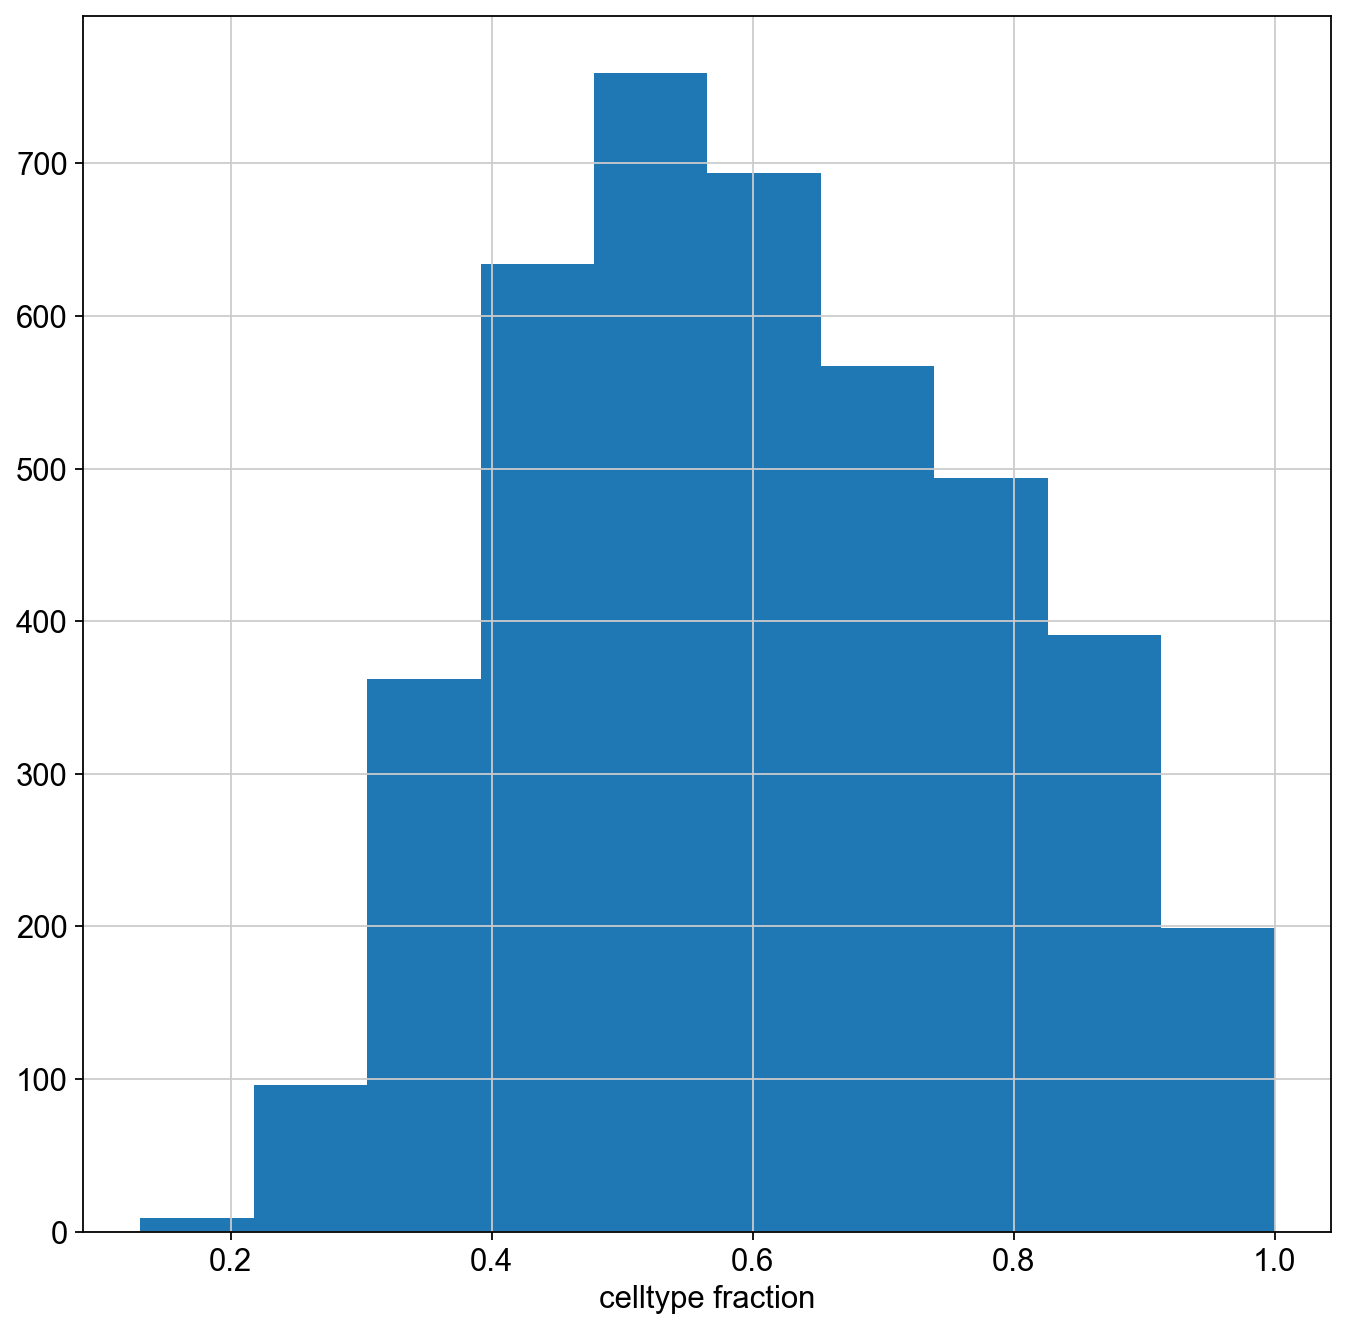

In [74]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [75]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

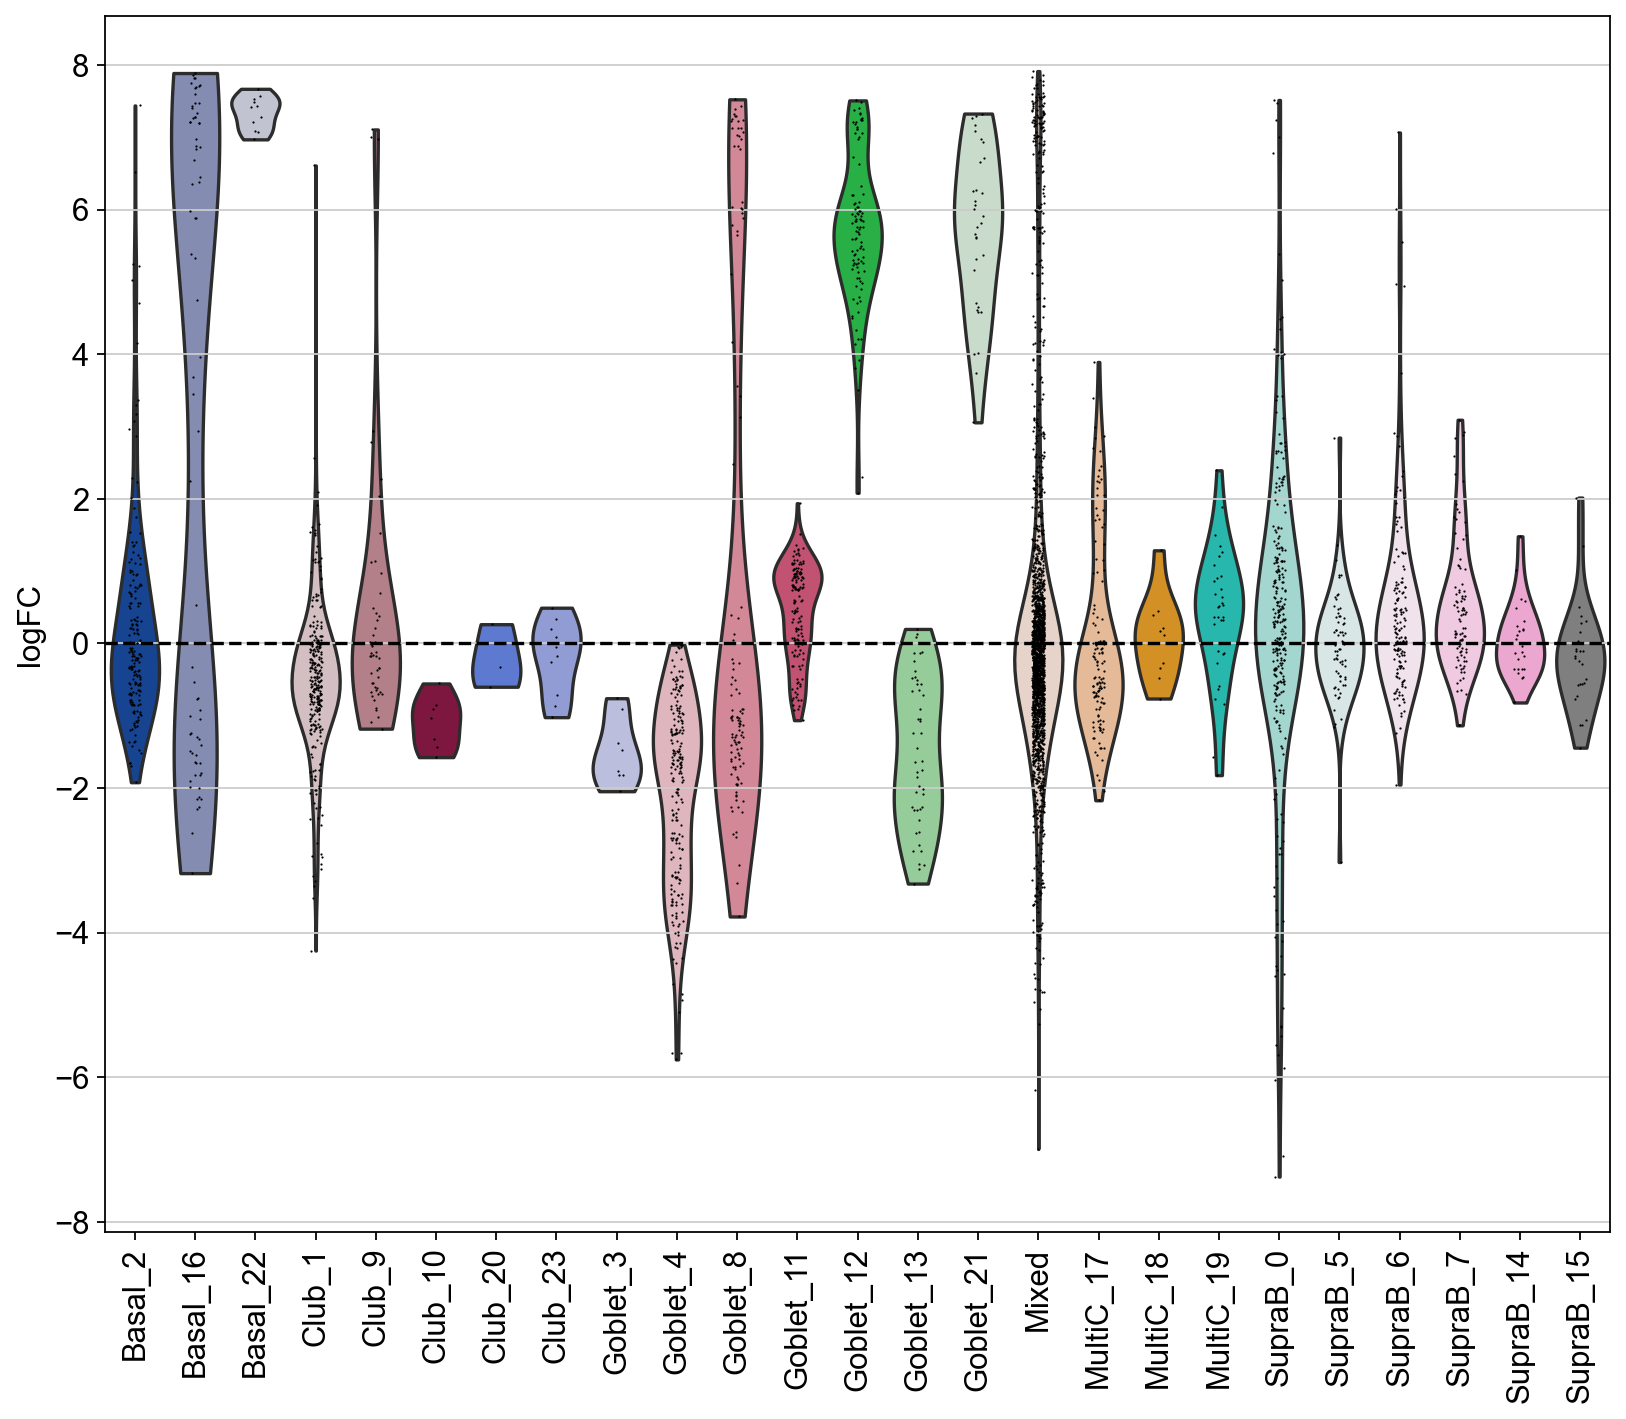

In [76]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# Healthy control vs. COPD+influenza

In [80]:
adata.obs['group'].value_counts()

copd_ctrl       30609
copd_iav        29157
healthy_ctrl    28175
healthy_iav     27161
Name: group, dtype: int64

In [81]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['healthy_ctrl', 'copd_iav'])]

In [82]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:22)


In [83]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [84]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [85]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
104170-ST07_CSE_CTRL-V1                  1          505.093658
504490-ST07_CSE_CTRL-V1                  1          270.533020
50854-ST07_CSE_CTRL-V1                   1          961.934265
411413-ST07_CSE_CTRL-V1                  1         1029.546265
176528-ST07_CSE_CTRL-V1                  1          502.989502
...                                    ...                 ...
10496296-CSE03_IAV-V6                    1          120.481613
2097861-CSE03_IAV-V6                     1          131.719528
6955026-CSE03_IAV-V6                     1          112.796806
12536461-CSE03_IAV-V6                    1           96.977776
9598877-CSE03_IAV-V6                     1           93.565697

[4348 rows x 2 columns]

In [86]:
milo.count_nhoods(adata, sample_col="sample")

In [87]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [88]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [89]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

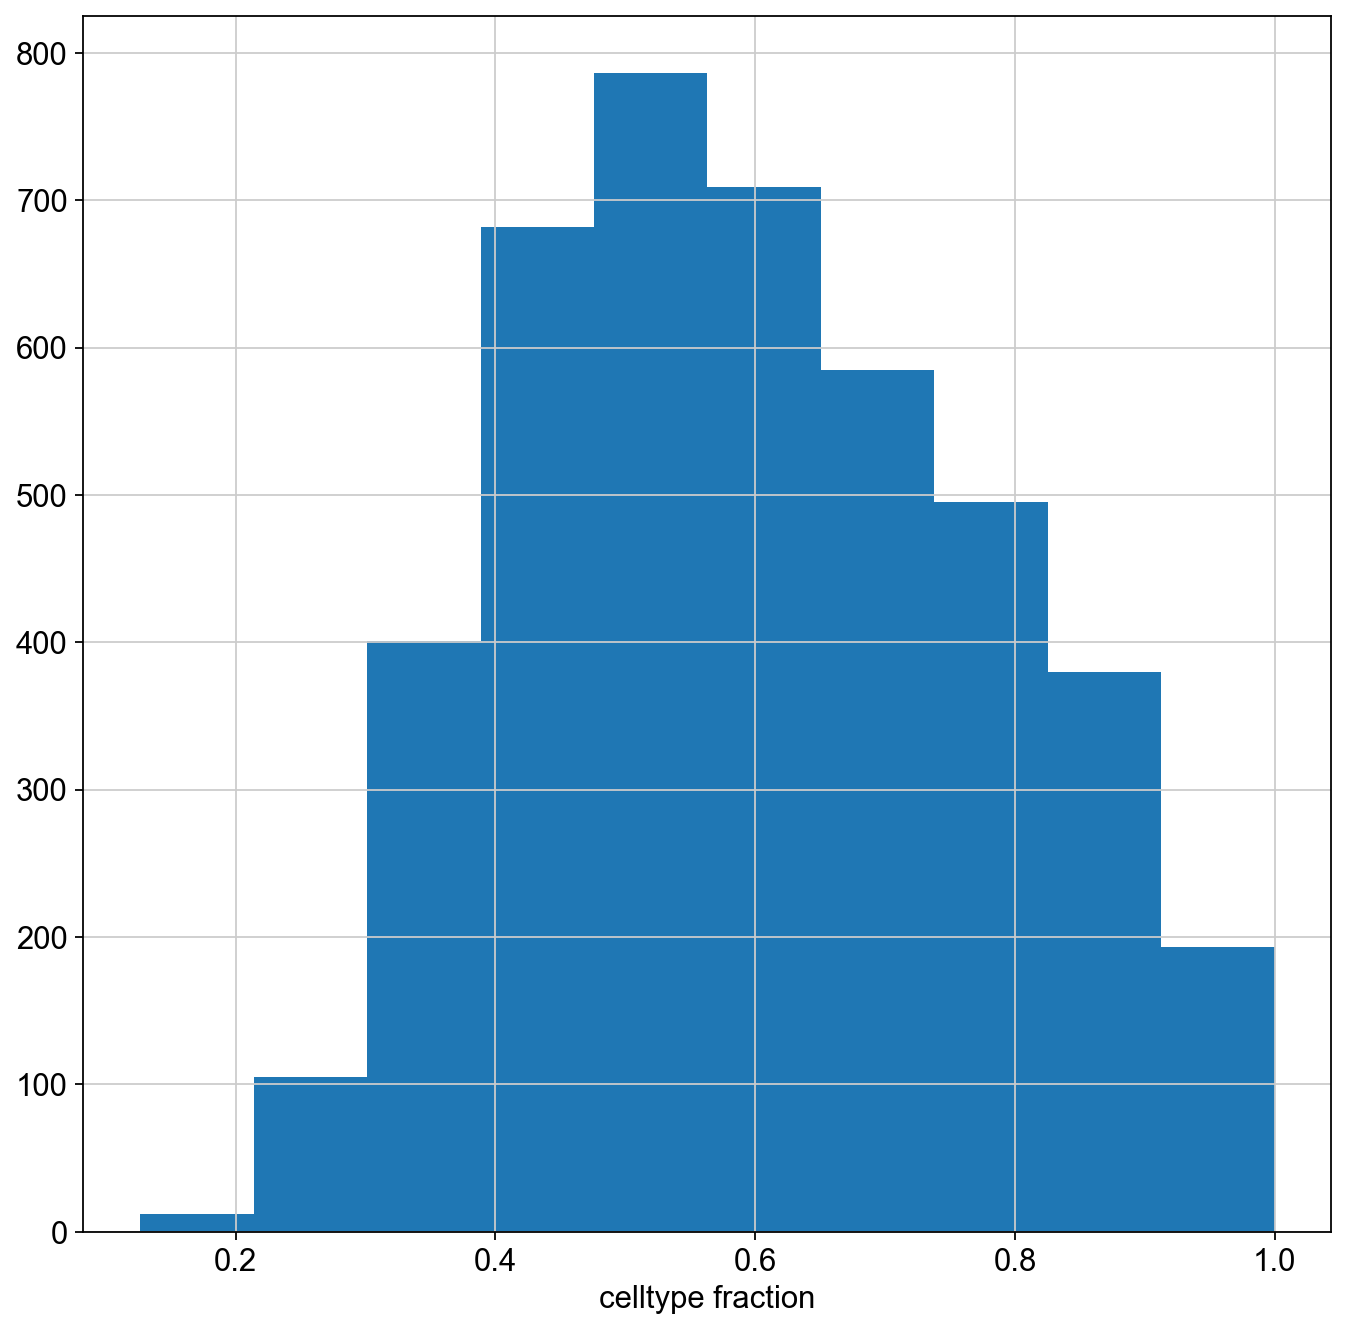

In [90]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [91]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

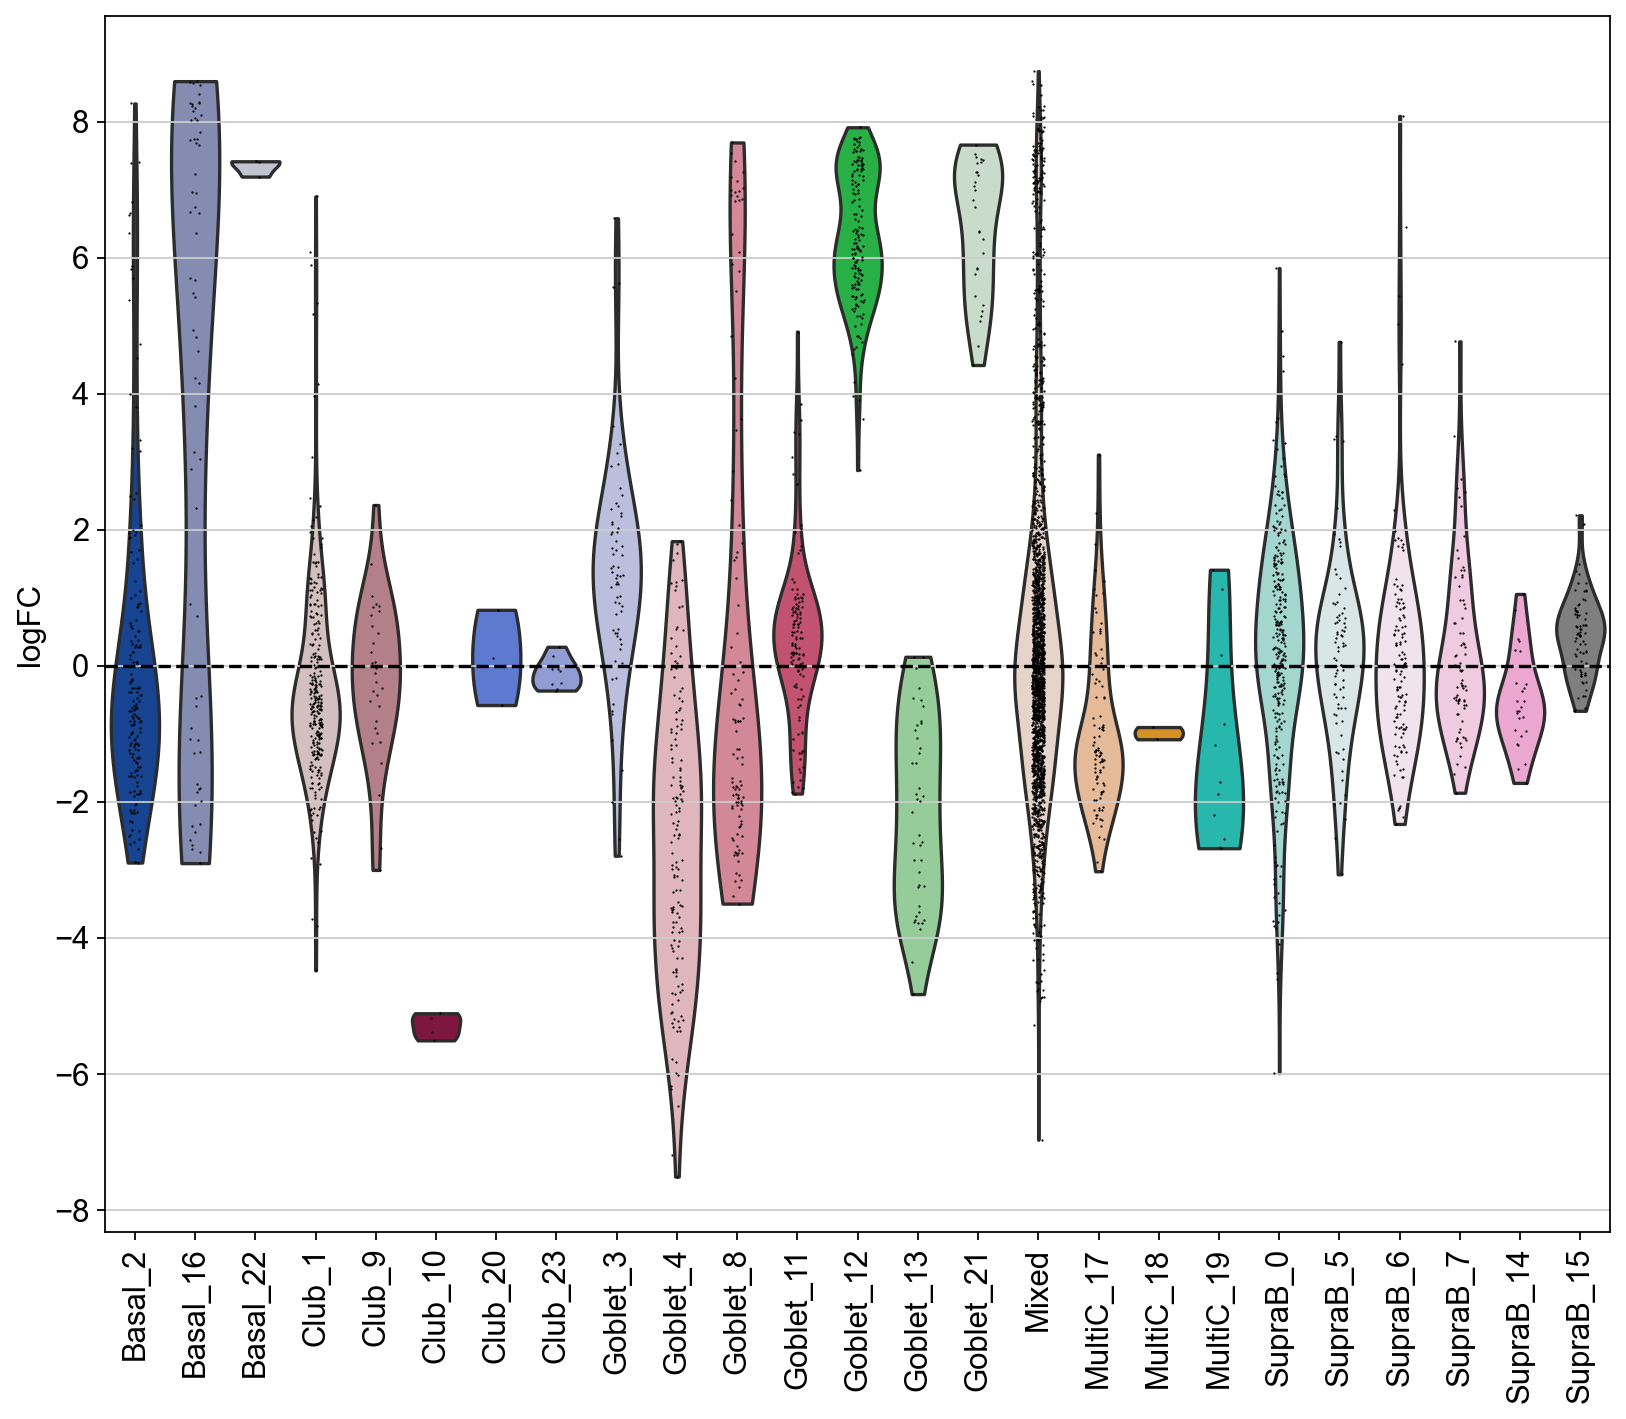

In [92]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# COPD vs. Influenza-infected

In [96]:
adata.obs['group'].value_counts()

copd_ctrl       30609
copd_iav        29157
healthy_ctrl    28175
healthy_iav     27161
Name: group, dtype: int64

In [97]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['copd_ctrl', 'healthy_iav'])]

In [98]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


In [99]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [100]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [101]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
282066-ST08_GnR_CTRL-V1                  1          649.591431
530724-ST08_GnR_CTRL-V1                  1          632.260803
534445-ST08_GnR_CTRL-V1                  1          585.325928
425906-ST08_GnR_CTRL-V1                  1          460.351593
451309-ST08_GnR_CTRL-V1                  1         1069.276123
...                                    ...                 ...
3572829-CSE03_CTRL-V6                    1          133.080688
3101244-CSE03_CTRL-V6                    1          114.267708
5458228-CSE03_CTRL-V6                    1          102.163315
475852-CSE03_CTRL-V6                     1          103.225342
13157829-CSE03_CTRL-V6                   1          131.043243

[4336 rows x 2 columns]

In [102]:
milo.count_nhoods(adata, sample_col="sample")

In [103]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [104]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [105]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

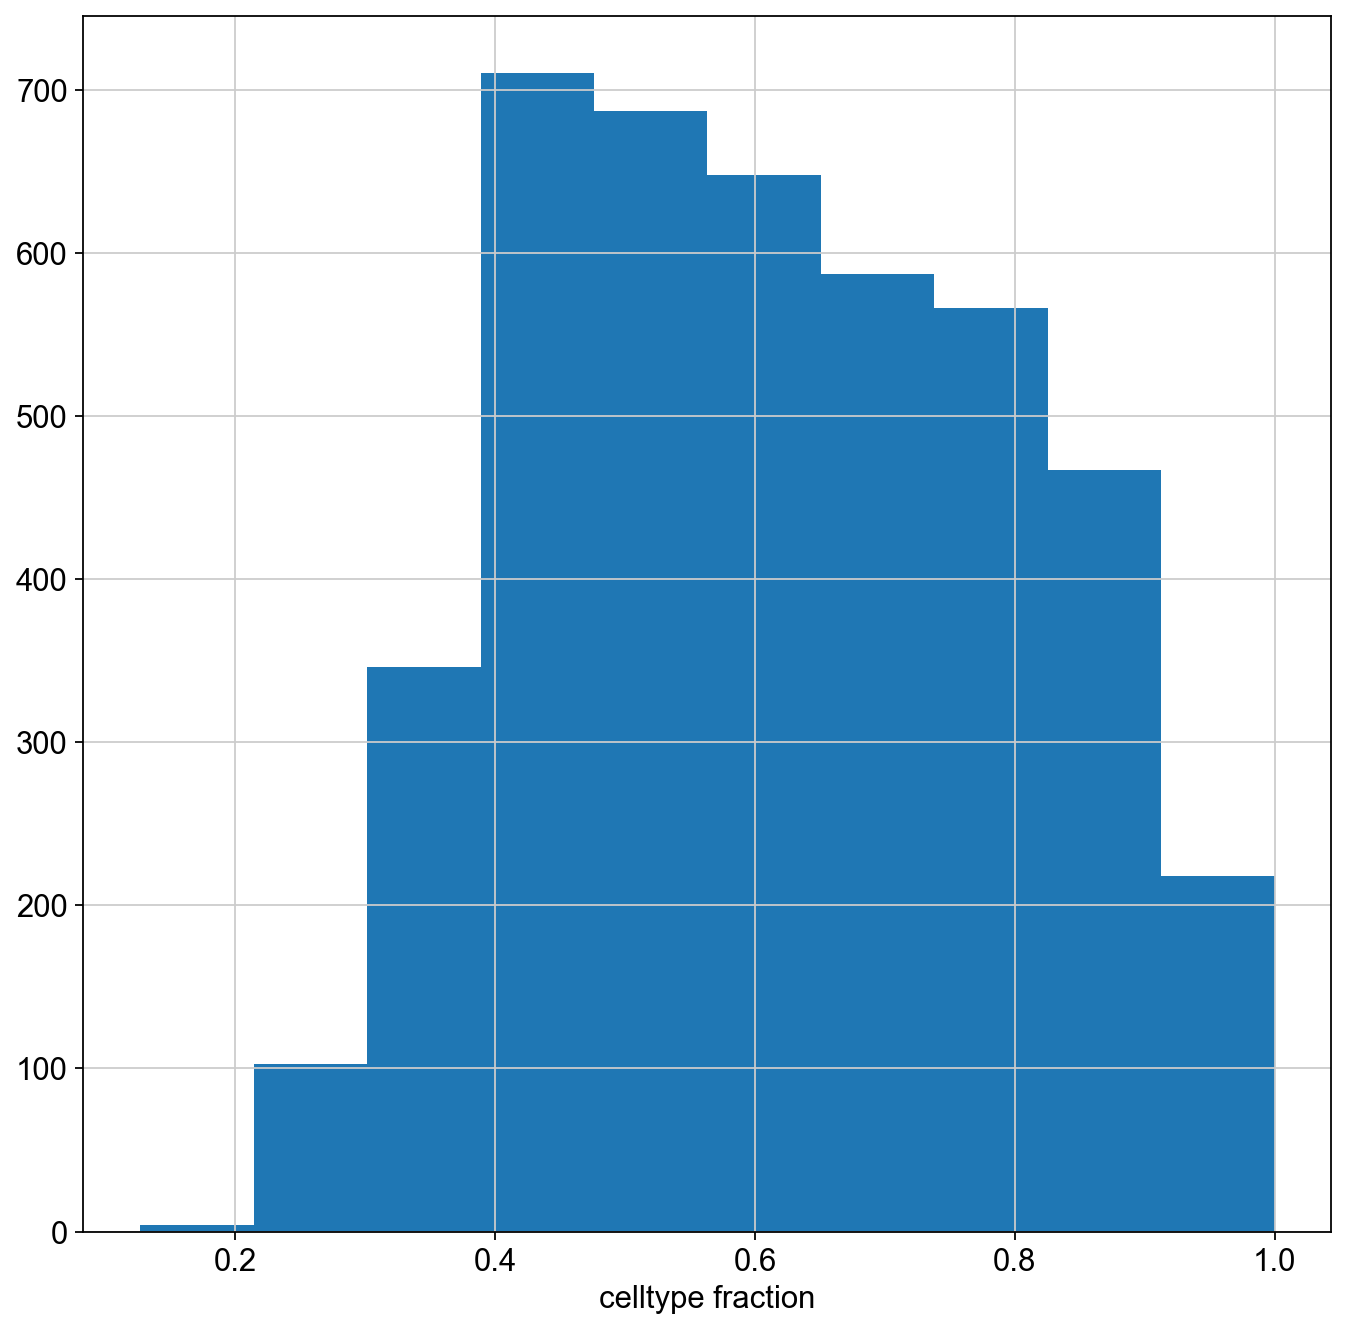

In [106]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [107]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

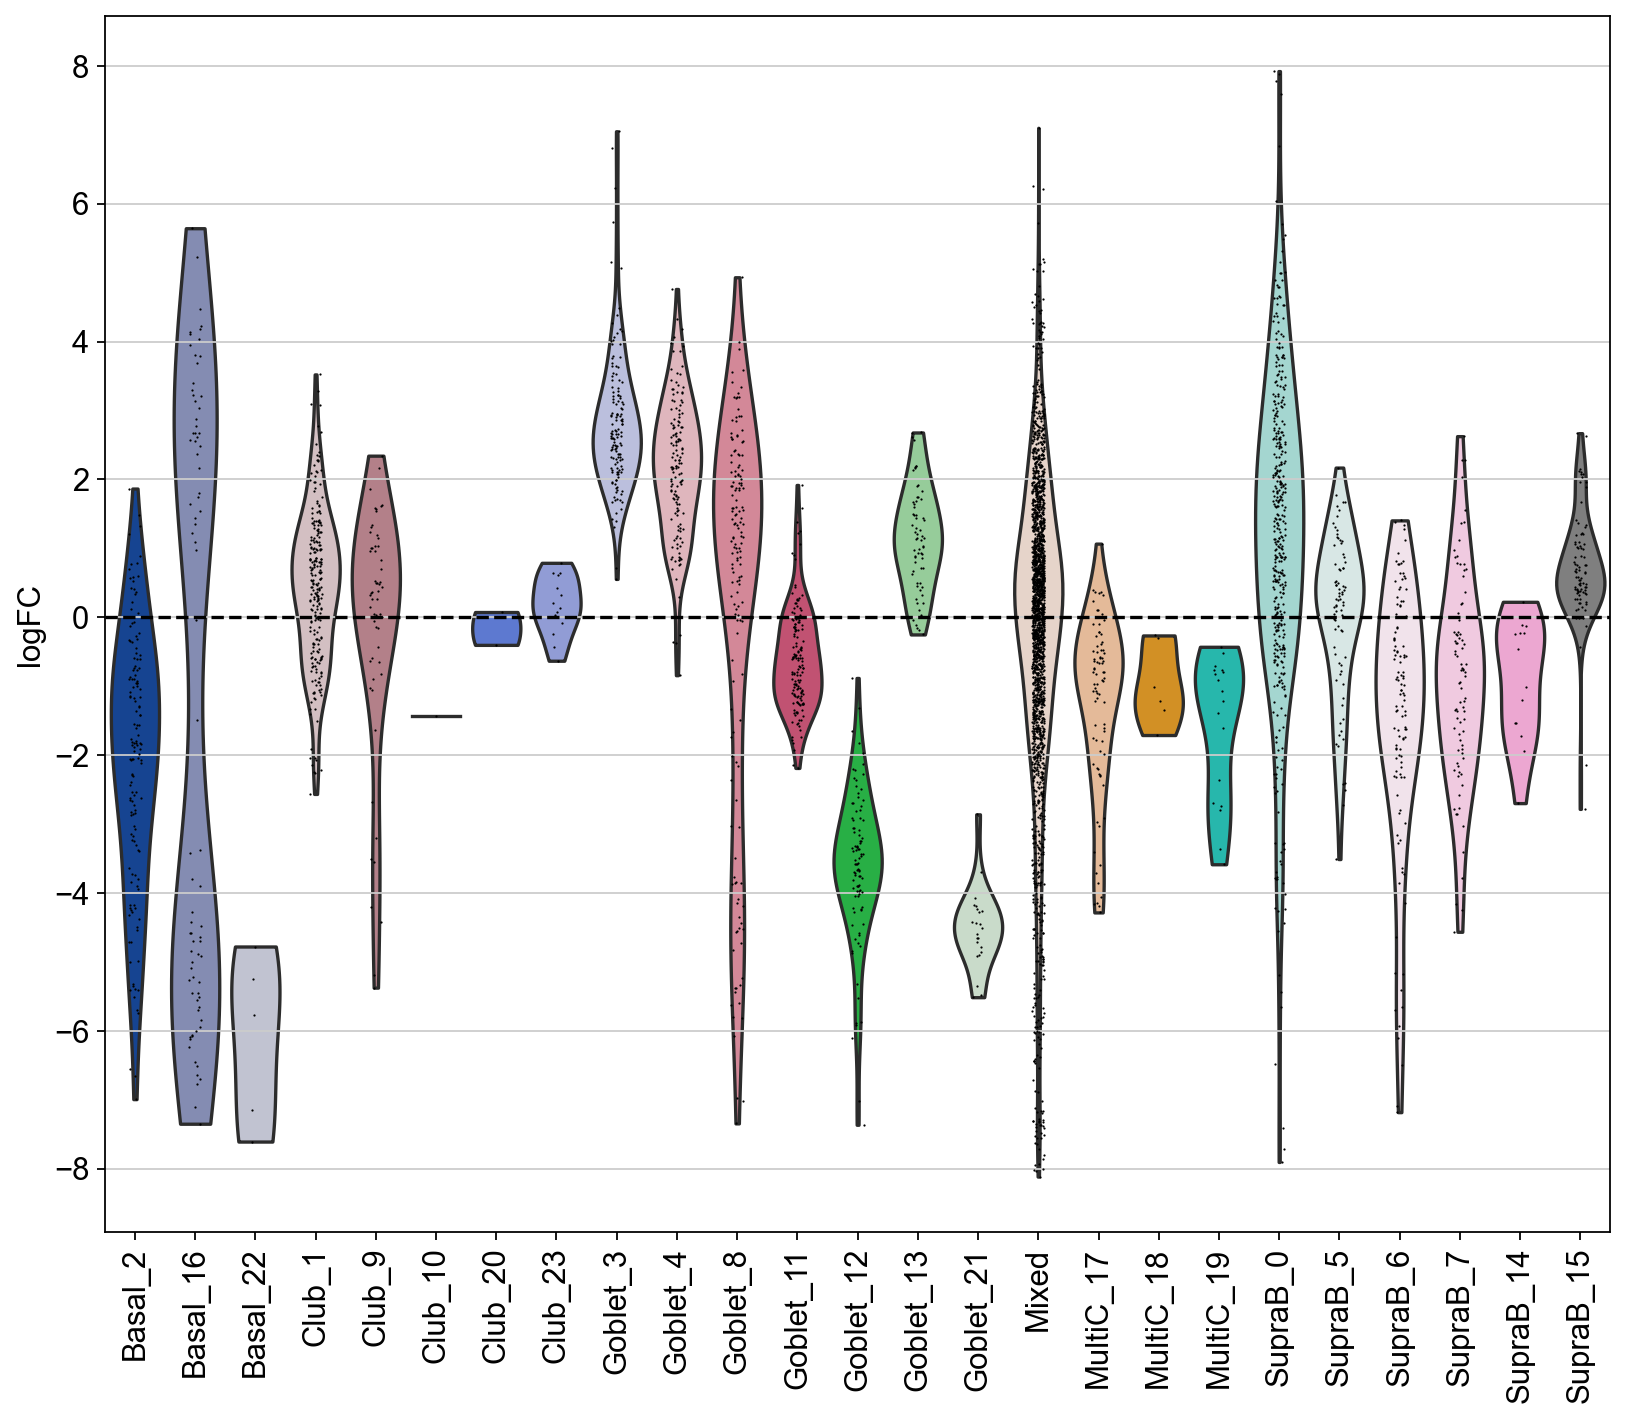

In [108]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# COPD vs. COPD+influenza

In [112]:
adata.obs['group'].value_counts()

copd_ctrl       30609
copd_iav        29157
healthy_ctrl    28175
healthy_iav     27161
Name: group, dtype: int64

In [113]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['copd_ctrl', 'copd_iav'])]

In [114]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:21)


In [115]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:16)


In [116]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [117]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
116883-ST09_CSE_IAV-V1                  1         5588.511719
799712-ST09_CSE_IAV-V1                  1         5239.966797
202778-ST09_CSE_IAV-V1                  1          761.395691
622679-ST09_CSE_IAV-V1                  1          426.207428
859699-ST09_CSE_IAV-V1                  1         1131.578125
...                                   ...                 ...
10649864-CSE03_IAV-V6                   1           98.673218
10767772-CSE03_IAV-V6                   1          165.903198
151392-CSE03_IAV-V6                     1          116.368011
12536461-CSE03_IAV-V6                   1           95.285004
11523087-CSE03_IAV-V6                   1          108.331810

[4468 rows x 2 columns]

In [118]:
milo.count_nhoods(adata, sample_col="sample")

In [119]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [120]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [121]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

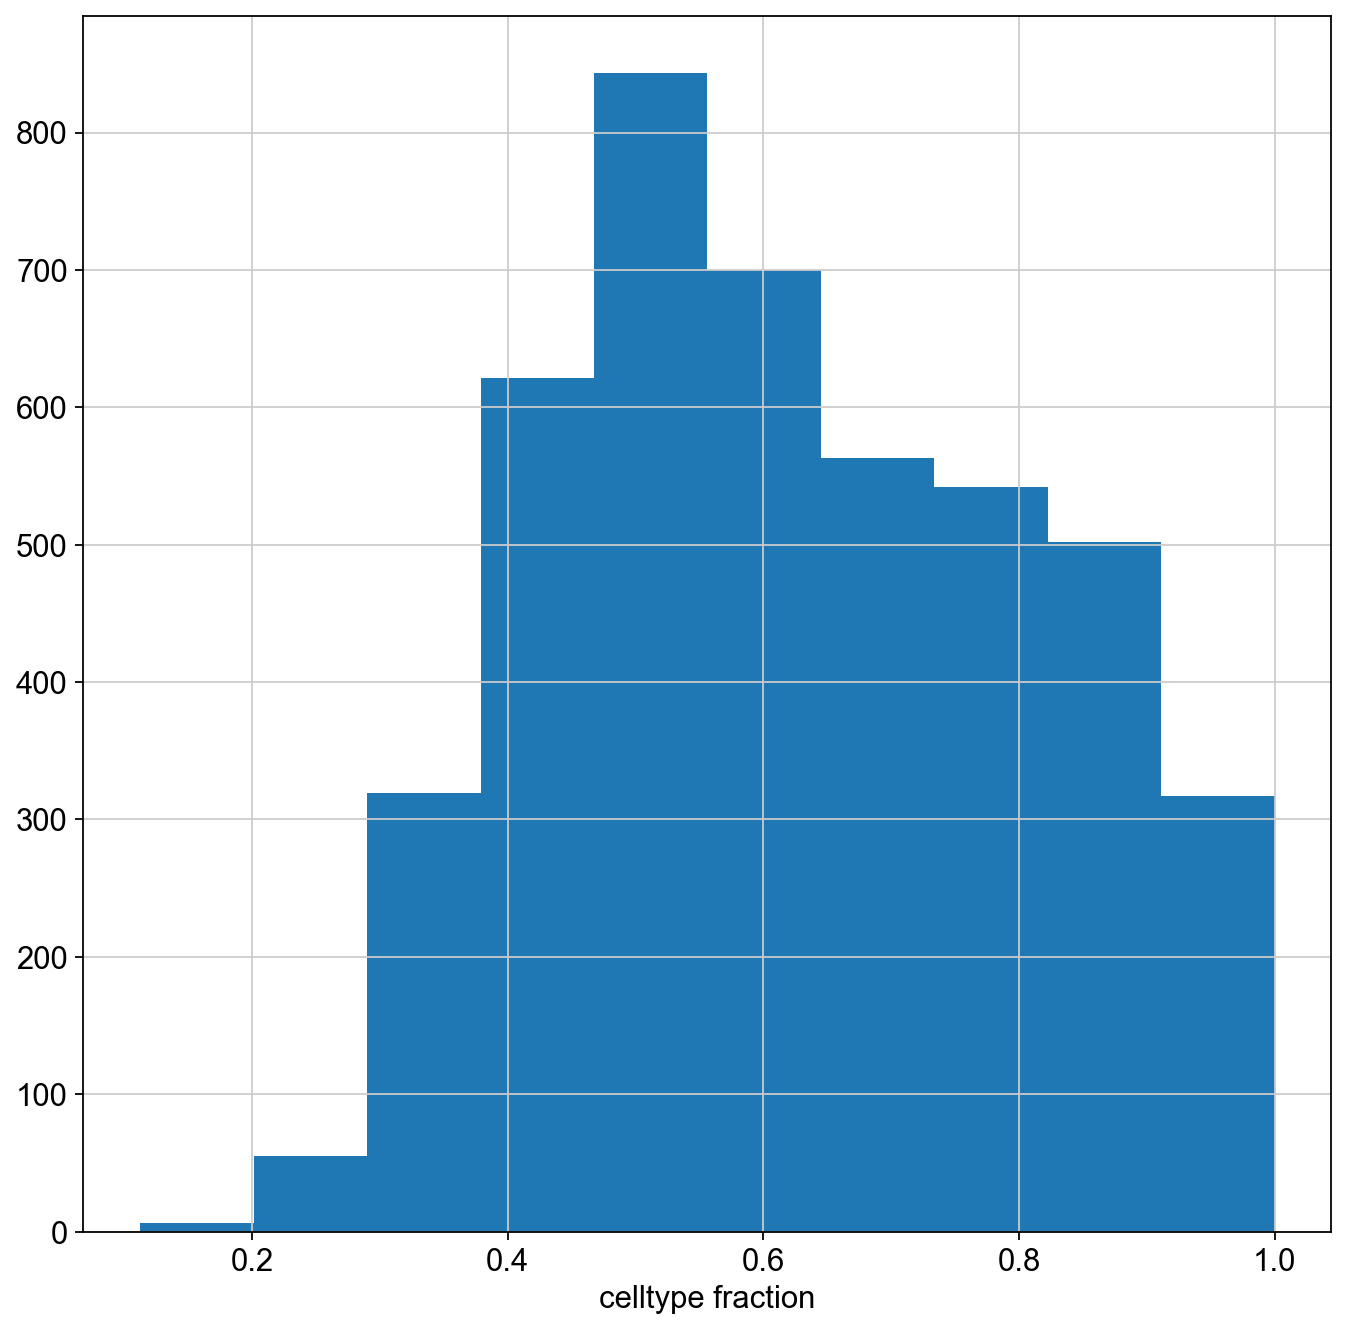

In [122]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [123]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

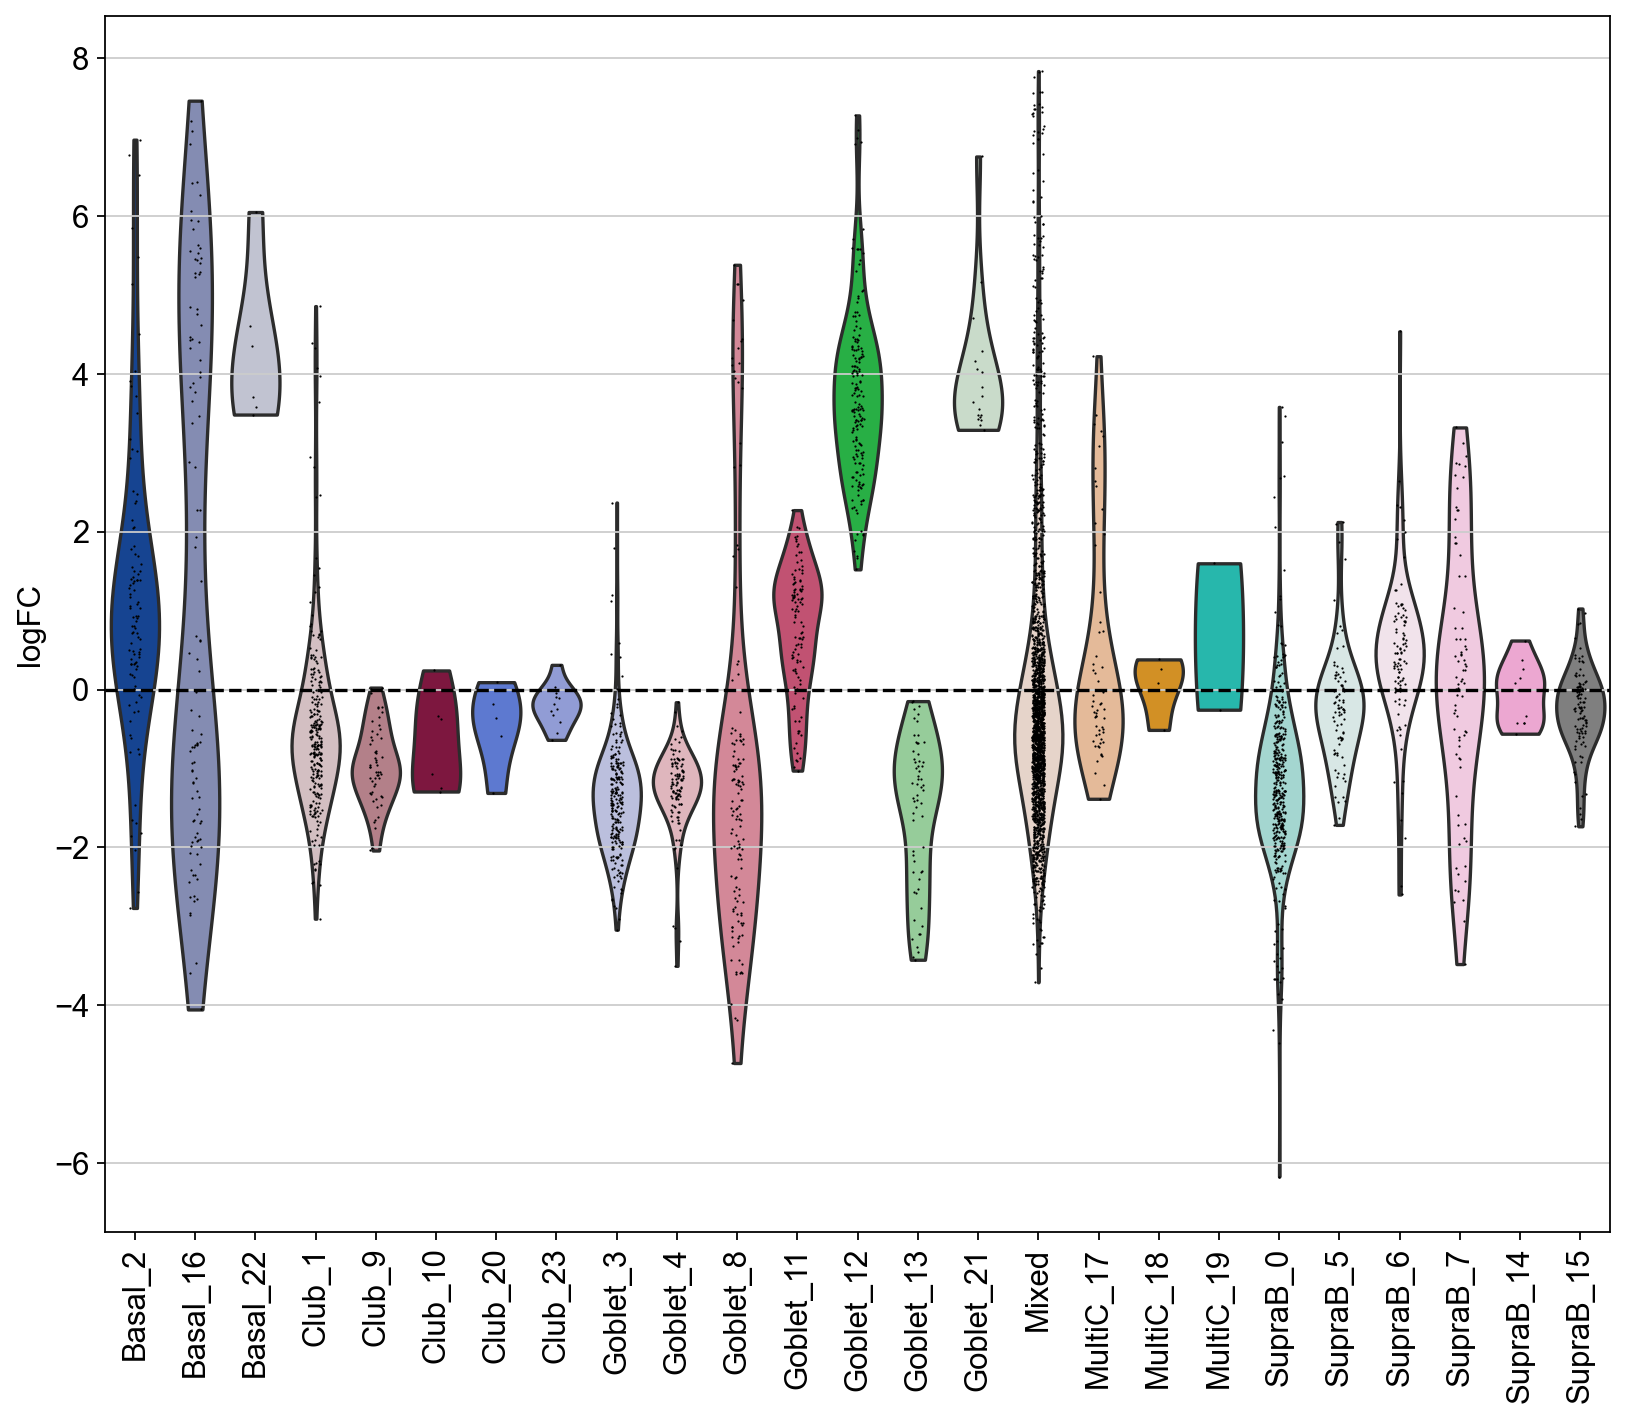

In [124]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()

# Influenza-infected vs. COPD+influenza

In [128]:
adata.obs['group'].value_counts()

copd_ctrl       30609
copd_iav        29157
healthy_ctrl    28175
healthy_iav     27161
Name: group, dtype: int64

In [129]:
# Filter only healthy_ctrl and COPD_ctrl cells
adata = adata[adata.obs['group'].isin(['healthy_iav', 'copd_iav'])]

In [130]:
# Calculate PCA 
sc.tl.pca(adata)

computing PCA
    on highly variable genes
    with n_comps=50
    finished (0:00:20)


In [131]:
#set the dimensionality and value for k to use in subsequent steps
d = 30
k = 50

sc.pp.neighbors(adata, n_neighbors=k, n_pcs=d)


computing neighbors
    using 'X_pca' with n_pcs = 30
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:14)


In [132]:
#Assign cells to a set of representative neighbourhoods on the KNN graph
milo.make_nhoods(adata, prop=0.1)

In [133]:
adata[adata.obs['nhood_ixs_refined'] != 0].obs[['nhood_ixs_refined', 'nhood_kth_distance']]

nhood_ixs_refined  nhood_kth_distance
282066-ST08_GnR_CTRL-V1                  1          645.931335
47453-ST08_GnR_CTRL-V1                   1          517.033875
715080-ST08_GnR_CTRL-V1                  1          680.723022
813402-ST08_GnR_CTRL-V1                  1          550.503418
430172-ST08_GnR_CTRL-V1                  1          745.539978
...                                    ...                 ...
1935448-CSE03_IAV-V6                     1          124.257416
10649864-CSE03_IAV-V6                    1          104.919640
1631627-CSE03_IAV-V6                     1          470.237762
450452-CSE03_IAV-V6                      1          138.274689
6955026-CSE03_IAV-V6                     1          118.128151

[4224 rows x 2 columns]

In [134]:
milo.count_nhoods(adata, sample_col="sample")

In [135]:
#convert the "stage" to a continuous variable, to test for linear increase over time
adata.obs["stage_continuous"] = adata.obs["group"].cat.codes

In [136]:
milo.DA_nhoods(adata, design="~stage_continuous")

/Users/anna.maguza/miniconda3/envs/milo_env/lib/python3.9/site-packages/milopy/core.py:285: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only.
  nhood_adata.obs = pd.concat([nhood_adata.obs, res], 1)


In [137]:
milopy.utils.annotate_nhoods(adata, anno_col='leiden_states')

Text(0.5, 0, 'celltype fraction')

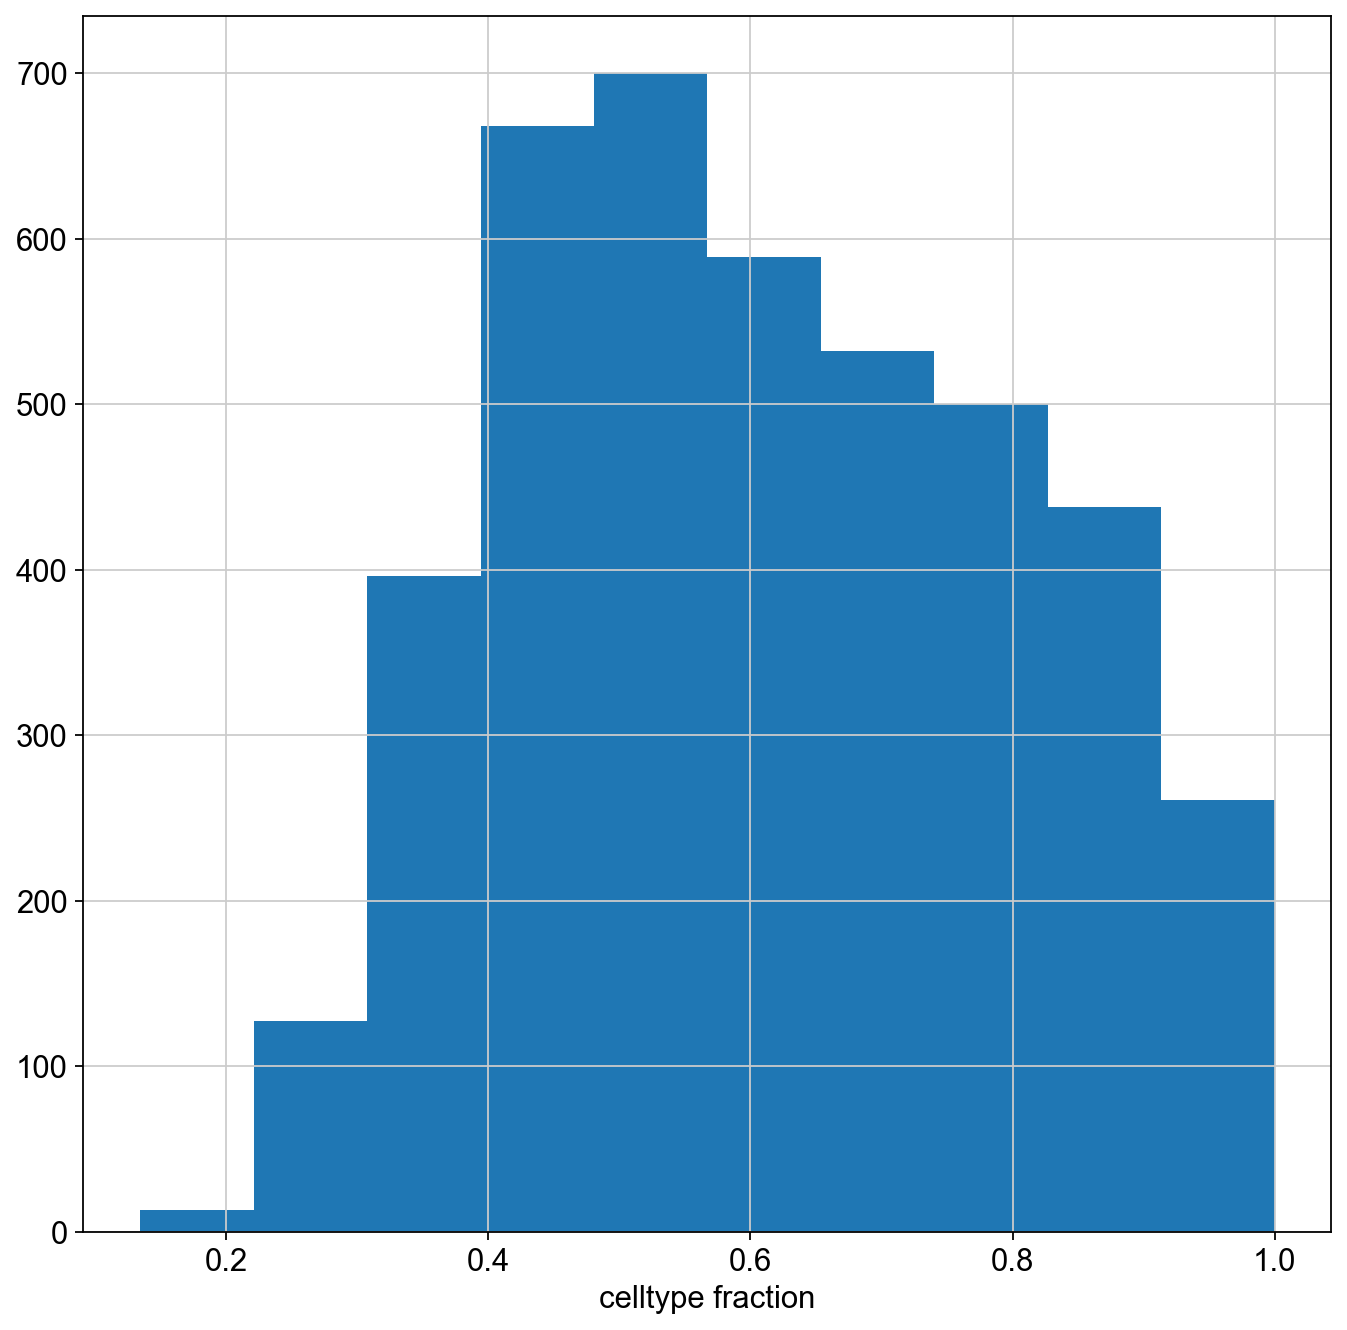

In [138]:
plt.hist(adata.uns['nhood_adata'].obs["nhood_annotation_frac"]);
plt.xlabel("celltype fraction")

In [139]:
adata.uns['nhood_adata'].obs.loc[adata.uns['nhood_adata'].obs["nhood_annotation_frac"] < 0.6, "nhood_annotation"] = "Mixed"

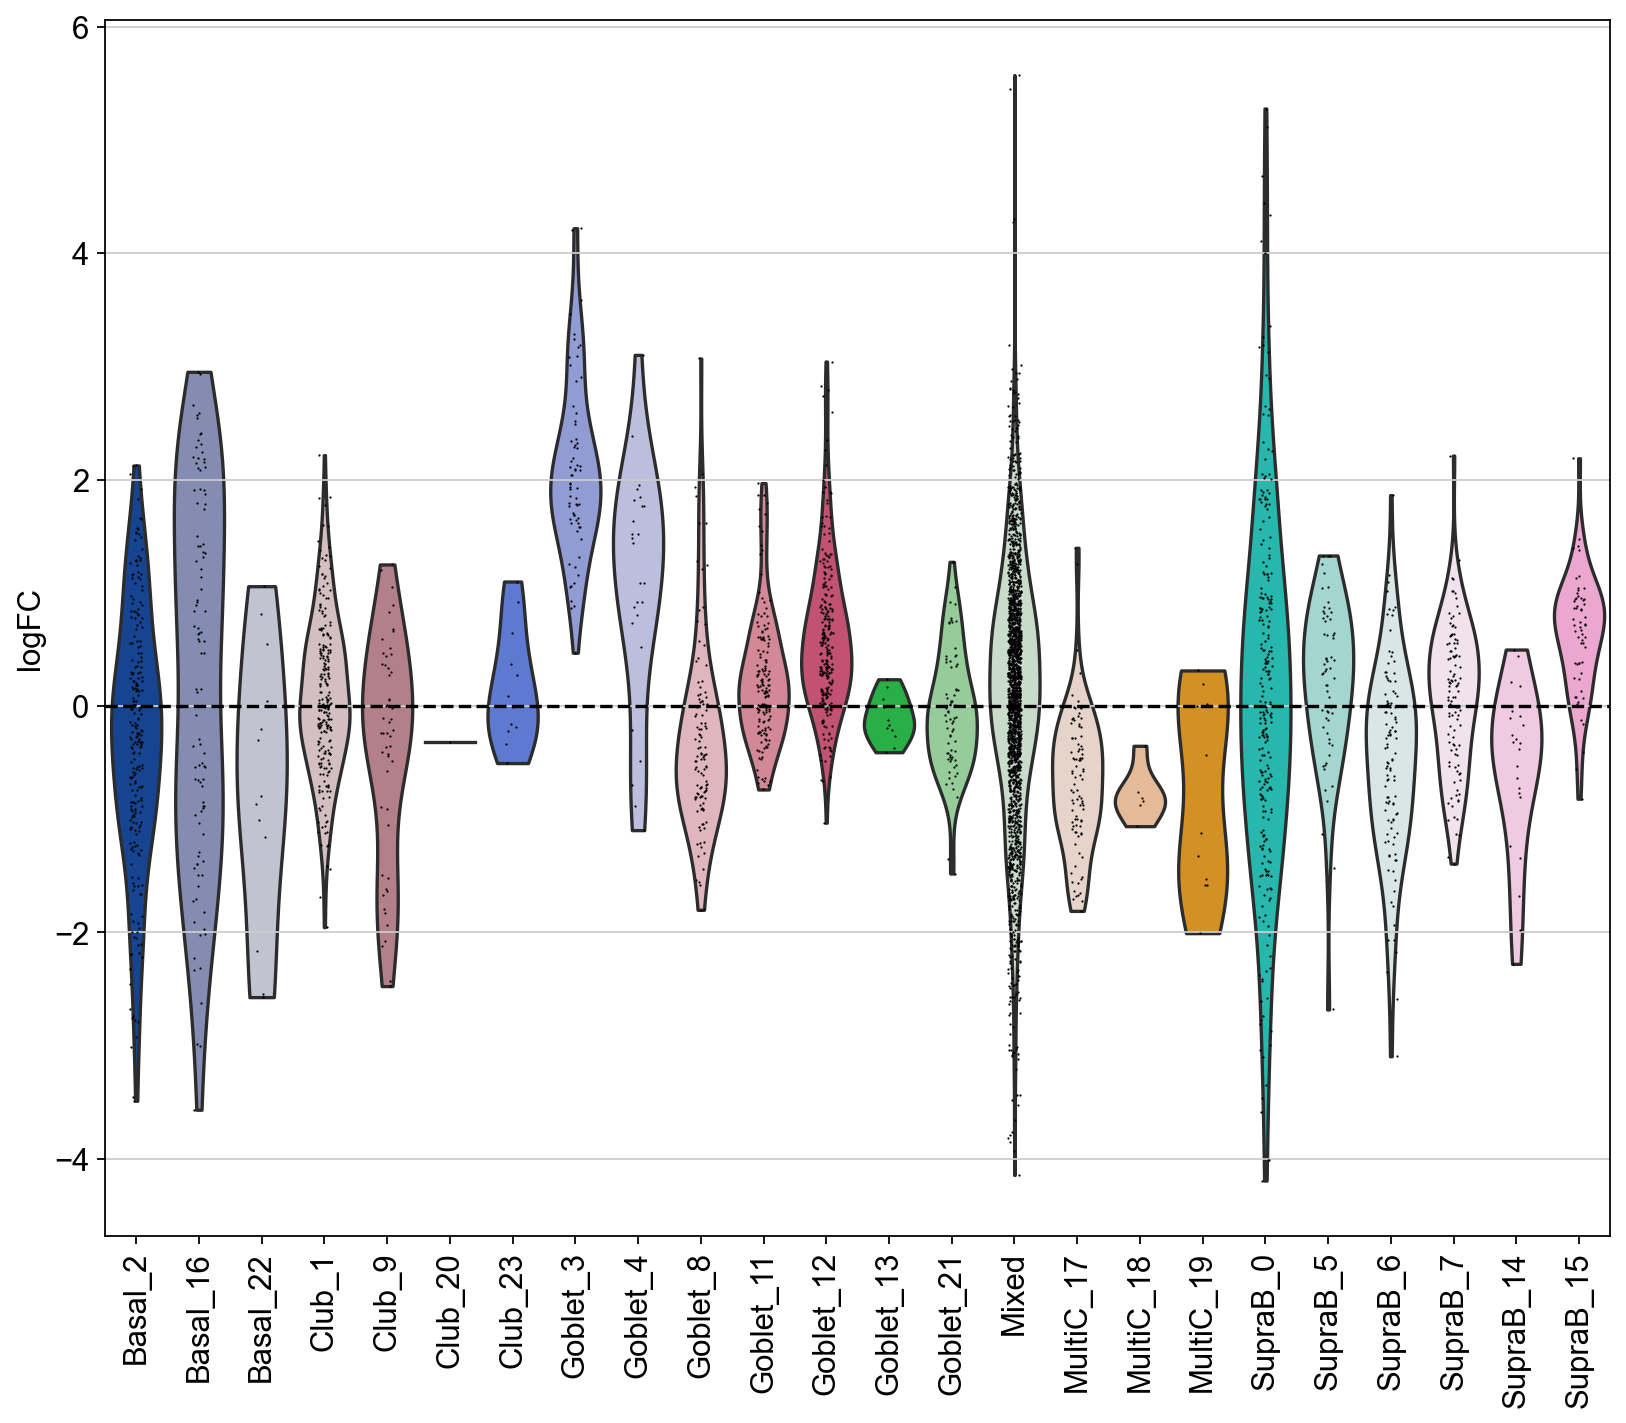

In [140]:
sc.pl.violin(adata.uns['nhood_adata'], "logFC", groupby="nhood_annotation", rotation=90, show=False);
plt.axhline(y=0, color='black', linestyle='--');
plt.show()